In [2]:
import os, glob, torch, sys, importlib
from pathlib import Path

# --- your actual paths on the node
BBJ_REPO_DIR = "/opt/gpudata/summereunann/protoecgnet"
PTBXL_WEIGHTS_ROOT = "/opt/gpudata/summereunann/ptbxl_weights"

assert os.path.isdir(BBJ_REPO_DIR), f"Repo dir missing: {BBJ_REPO_DIR}"
sys.path.insert(0, BBJ_REPO_DIR)

# Find candidate checkpoints
candidates = []
for ext in ("*.ckpt","*.pth","*.pt","*.safetensors"):
    candidates += glob.glob(os.path.join(PTBXL_WEIGHTS_ROOT, "**", ext), recursive=True)

def _ckpt_kind(path):
    try:
        sd = torch.load(path, map_location="cpu")
    except Exception:
        return "unreadable"
    if isinstance(sd, dict) and "state_dict" in sd:
        return "lightning_ckpt"
    if isinstance(sd, dict):
        # raw state_dict-like
        return "raw_state_dict"
    return "unknown"

annot = [(p, _ckpt_kind(p)) for p in sorted(candidates)]
for p, k in annot:
    print(f"{k:16} -> {p}")

# Heuristic: prefer Lightning ckpt with 'ptb' & 'xl' in name; avoid anything with 'echonext' in the filename
CKPT_PATH = None
for p, k in annot:
    name = os.path.basename(p).lower()
    if k == "lightning_ckpt" and ("ptb" in name and "xl" in name) and ("echonext" not in name):
        CKPT_PATH = p
        break

# Fallbacks
if CKPT_PATH is None:
    for p, k in annot:
        if k == "lightning_ckpt":
            CKPT_PATH = p; break
if CKPT_PATH is None and annot:
    CKPT_PATH = annot[0][0]

print("\nChosen CKPT_PATH:", CKPT_PATH)


lightning_ckpt   -> /opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt
lightning_ckpt   -> /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt

Chosen CKPT_PATH: /opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt


In [4]:
import torch, json, itertools
ckpt_obj = torch.load(ckpt, map_location="cpu")

# What top-level keys?
print("Top-level keys:", list(ckpt_obj.keys()))

# Show a few state_dict keys (prefixes hint at original class names)
sd_keys = list(ckpt_obj.get("state_dict", {}).keys())
print("Total state_dict keys:", len(sd_keys))
print("First 20 keys:", sd_keys[:20])

# Many pl checkpoints store hyperparameters/metadata:
for k in ["hyper_parameters","hparams","trainer_state","pytorch-lightning_version"]:
    if k in ckpt_obj:
        print(f"{k}:", ckpt_obj[k] if isinstance(ckpt_obj[k], (str,int,float)) else "present")

# Heuristics to guess dataset/labels from hparams text blobs if present
hp = ckpt_obj.get("hyper_parameters") or ckpt_obj.get("hparams")
if isinstance(hp, dict):
    print("\n=== Hyperparameters (subset) ===")
    for key in ["dataset","data_name","task","num_classes","sample_rate","input_seconds","leads","class_names"]:
        if key in hp:
            print(f"{key}: {hp[key]}")


Top-level keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters']
Total state_dict keys: 130
First 20 keys: ['model.prototype_vectors', 'model.ones', 'model.prototype_class_identity', 'model.feature_extractor.resnet.conv1.weight', 'model.feature_extractor.resnet.bn1.weight', 'model.feature_extractor.resnet.bn1.bias', 'model.feature_extractor.resnet.bn1.running_mean', 'model.feature_extractor.resnet.bn1.running_var', 'model.feature_extractor.resnet.bn1.num_batches_tracked', 'model.feature_extractor.resnet.layer1.0.conv1.weight', 'model.feature_extractor.resnet.layer1.0.bn1.weight', 'model.feature_extractor.resnet.layer1.0.bn1.bias', 'model.feature_extractor.resnet.layer1.0.bn1.running_mean', 'model.feature_extractor.resnet.layer1.0.bn1.running_var', 'model.feature_extractor.resnet.layer1.0.bn1.num_batches_tracked', 'model.feature_extractor.resnet.layer1.0.conv2.weight', 'mode

# E0 plan (one screen)

Purpose. Before any modeling, quantify whether PTB-XL ProtoECGNet embeddings/prototypes carry SHD signal on EchoNext.

Inputs

Checkpoint: PTB-XL–trained ProtoECGNet (weights only).

Data: EchoNext with official patient-level splits (use the split column).

Preprocessing

12-lead, crop/pad to 10s equivalent; resample to match the PTB-XL config (commonly 100 Hz).

Per-lead z-normalize; no label/ICD/echo leakage features.

What to compute (no weight updates)

Prototype activations per ECG (vector of similarities).

Univariate signal: for each SHD label, AUC of every activation dimension (positives vs. negatives).

(Optional E0b) Frozen-feature linear probe (LogReg or 1× linear layer) → AUROC/AUPRC; no finetuning of encoder/prototypes.

Calibration on the probe: ECE, Brier, reliability plot.

(Optional) A very small prototype gallery (top-k prototypes most associated with any SHD label). If you want to avoid images entirely in E0, keep this off and just export IDs/nearest-neighbor indices.

# Got the weight from: https://drive.google.com/drive/folders/1xYcpSKotubnwnYQfn_7xxlygnq1KmbOO

In [40]:
import os, json, math, warnings, glob, sys
from pathlib import Path

# === YOUR PATHS ===
ECHONEXT_PATH = "/opt/gpudata/ecg/echonext"
PTBXL_WEIGHTS_PATH = "/opt/gpudata/summereunann/ptbxl_weights/protoecgnet.pth"
RESULTS_DIR = "results/experiment_1/"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optional: if the original ProtoECGNet repo is checked out somewhere, set this:
PROTOECGNET_REPO_DIR = None  # e.g., "/opt/gpudata/summereunann/protoecgnet" or None
if PROTOECGNET_REPO_DIR and PROTOECGNET_REPO_DIR not in sys.path:
    sys.path.append(PROTOECGNET_REPO_DIR)

# Inference config
SRC_HZ = 250      # EchoNext native
TGT_HZ = 100      # PTB-XL common (ProtoECGNet default)
CLIP_SECONDS = 10
BATCH_SIZE = 64
DEVICE = "cuda" if (os.environ.get("CUDA_VISIBLE_DEVICES") not in (None, "") ) else "cpu"
SEED = 41

warnings.filterwarnings("ignore")
print("Device:", DEVICE)


Device: cpu


In [41]:
import pandas as pd
import numpy as np

def _looks_like_meta(df: pd.DataFrame) -> bool:
    if "split" not in df.columns: return False
    num = df.select_dtypes(include=["number","bool"]).columns.tolist()
    cand = []
    for c in num:
        if c.lower() == "split": continue
        vals = pd.Series(df[c].dropna().unique())
        if (vals.isin([0,1]).all()) or (set(vals.astype(int).unique()).issubset({0,1})):
            cand.append(c)
    return len(cand) >= 3

def find_meta(base):
    cands = sorted(glob.glob(os.path.join(base, "**", "*.csv"), recursive=True))
    # Prefer files whose name contains 'echonext' or 'meta'
    cands = sorted(cands, key=lambda p: (0 if any(k in os.path.basename(p).lower() for k in ("echonext","meta")) else 1, len(p)))
    for p in cands:
        try:
            df = pd.read_csv(p, nrows=1000)
            if _looks_like_meta(df):
                return p
        except Exception:
            pass
    raise FileNotFoundError("Could not locate EchoNext metadata CSV under " + base)

ECHONEXT_META_CSV = find_meta(ECHONEXT_PATH)
meta = pd.read_csv(ECHONEXT_META_CSV)
print("Found metadata:", ECHONEXT_META_CSV, "  rows:", len(meta), "  cols:", len(meta.columns))

# Infer SHD label columns (binary)
IGNORE = {"split","fold","patient_id","subject_id","recording_id","ecg_id","age","sex","site","year"}
cand = []
for c in meta.select_dtypes(include=["number","bool"]).columns:
    if c in IGNORE: continue
    vals = pd.Series(meta[c].dropna().unique())
    if (vals.isin([0,1]).all()) or (set(vals.astype(int).unique()).issubset({0,1})):
        cand.append(c)
# Prefer SHD-ish names
pri = [c for c in cand if any(k in c.lower() for k in ["stenosis","regurg","valv","cardiomy","hcm","dcm","lv","rv","shd","as","mr","ms","ar","tr","ti"])]
SHD_LABELS = pri if len(pri) >= 3 else cand
print("SHD_LABELS:", SHD_LABELS[:10], "..." if len(SHD_LABELS)>10 else "")


Found metadata: /opt/gpudata/ecg/echonext/EchoNext_metadata_100k.csv   rows: 100000   cols: 35
SHD_LABELS: ['lvef_lte_45_flag', 'lvwt_gte_13_flag', 'aortic_stenosis_moderate_or_greater_flag', 'aortic_regurgitation_moderate_or_greater_flag', 'mitral_regurgitation_moderate_or_greater_flag', 'tricuspid_regurgitation_moderate_or_greater_flag', 'pulmonary_regurgitation_moderate_or_greater_flag', 'rv_systolic_dysfunction_moderate_or_greater_flag', 'pericardial_effusion_moderate_large_flag', 'pasp_gte_45_flag'] ...


In [42]:
import torch, sys, subprocess, shlex

print("Torch version:", torch.__version__, "| CUDA:", torch.version.cuda)
!pip -q install --no-input scipy

from scipy.signal import resample_poly

def remove_baseline_wander(x, fs):
    # simple high-pass via polynomial detrend per-lead
    # (replace with a proper filter if you prefer)
    return x - np.polyval(np.polyfit(np.arange(x.shape[1]), x, deg=1), np.arange(x.shape[1]))

def preprocess_fn(src_hz=SRC_HZ, tgt_hz=TGT_HZ, seconds=CLIP_SECONDS):
    tgt_len = tgt_hz * seconds
    def _f(ecg_12xT):
        # resample
        if src_hz != tgt_hz:
            ecg = np.stack([resample_poly(lead, tgt_hz, src_hz) for lead in ecg_12xT], axis=0)
        else:
            ecg = ecg_12xT
        # simple detrend
        ecg = remove_baseline_wander(ecg, fs=tgt_hz)
        # standardize per-lead
        mu = ecg.mean(axis=1, keepdims=True)
        sd = ecg.std(axis=1, keepdims=True) + 1e-6
        ecg = (ecg - mu) / sd
        # clip/pad to tgt_len
        T = ecg.shape[1]
        if T >= tgt_len:
            ecg = ecg[:, :tgt_len]
        else:
            pad = np.zeros((12, tgt_len - T), dtype=ecg.dtype)
            ecg = np.concatenate([ecg, pad], axis=1)
        return ecg
    return _f

pproc = preprocess_fn()

# Map torch → torchvision versions (common pairs)
MAP = {
    "2.5": "0.20",
    "2.4": "0.19",
    "2.3": "0.18",
    "2.2": "0.17",
    "2.1": "0.16",
    "2.0": "0.15",
}
tv = MAP.get(torch.__version__[:3])  # best effort
extra = ""
if torch.version.cuda:
    cu = "cu" + torch.version.cuda.replace(".", "")
    extra = f"--extra-index-url https://download.pytorch.org/whl/{cu}"

# Build pip command
if tv:
    cmd = f"pip install -U {extra} torchvision=={tv}.*"
else:
    # Fallback if mapping misses your torch version
    cmd = f"pip install -U {extra} torchvision"

print("Installing with:\n ", cmd)
res = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
print(res.stdout)


Torch version: 2.0.1+cu117 | CUDA: 11.7
Installing with:
  pip install -U --extra-index-url https://download.pytorch.org/whl/cu117 torchvision==0.15.*
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Requirement already up-to-date: torchvision==0.15.* in ./protoecgnet-env/lib/python3.8/site-packages (0.15.2+cu117)
  Using cached triton-2.0.0-1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.2 MB)
ERROR: pytorch-lightning 2.4.0 has requirement torch>=2.1.0, but you'll have torch 2.0.1+cu117 which is incompatible.
  Attempting uninstall: triton
    Found existing installation: triton 3.0.0
    Uninstalling triton-3.0.0:
      Successfully uninstalled triton-3.0.0
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1



In [45]:
# === REAL PATHS (from your directory listing) ===
ECHONEXT_PATH = "/opt/gpudata/ecg/echonext"
ECHONEXT_META_CSV = f"{ECHONEXT_PATH}/EchoNext_metadata_100k.csv"

# PTB-XL weights (unchanged here)
PROTOECGNET_CKPT = "/opt/gpudata/summereunann/ptbxl_weights/protoecgnet.pth"

# Output dir
OUTDIR = "results/echonext_E0_zeroshot"
os.makedirs(OUTDIR, exist_ok=True)

# Use the official split-level waveforms that already exist on disk
WAVEFORMS_NPY_PATHS = {
    "train": f"{ECHONEXT_PATH}/EchoNext_train_waveforms.npy",
    "val":   f"{ECHONEXT_PATH}/EchoNext_val_waveforms.npy",
    "test":  f"{ECHONEXT_PATH}/EchoNext_test_waveforms.npy",
}

# (Optional) tabular features — we only use them to verify alignment lengths
TABULAR_NPY_PATHS = {
    "train": f"{ECHONEXT_PATH}/EchoNext_train_tabular_features.npy",
    "val":   f"{ECHONEXT_PATH}/EchoNext_val_tabular_features.npy",
    "test":  f"{ECHONEXT_PATH}/EchoNext_test_tabular_features.npy",
}

# Load metadata
meta = pd.read_csv(ECHONEXT_META_CSV)
print(f"meta shape: {meta.shape}; columns:\n{list(meta.columns)}")

# Ensure there is a 'split' column; if not, infer from counts (will error out loudly)
assert "split" in meta.columns, "EchoNext metadata must have a 'split' column."

# Try to auto-detect SHD label columns: binary {0,1} with reasonable prevalence
candidate_cols = []
for c in meta.columns:
    if meta[c].dtype in (int, float, np.int64, np.float64, "int64", "float64"):
        vals = pd.Series(meta[c].dropna().unique())
        if set(vals.tolist()).issubset({0, 1}) and 0 < meta[c].mean() < 0.9:
            candidate_cols.append(c)

print("Candidate SHD label columns (auto-detected):", candidate_cols)

# If you already know the exact columns, hard-code them here and override:
# SHD_LABELS = ["as_label", "mr_label", ...]
SHD_LABELS = candidate_cols
assert len(SHD_LABELS) > 0, "No SHD label columns detected. Please set SHD_LABELS manually."


meta shape: (100000, 35); columns:
['ecg_key', 'patient_key', 'age_at_ecg', 'sex', 'acquisition_year', 'ventricular_rate', 'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'lvef_lte_45_flag', 'lvwt_gte_13_flag', 'aortic_stenosis_moderate_or_greater_flag', 'aortic_regurgitation_moderate_or_greater_flag', 'mitral_regurgitation_moderate_or_greater_flag', 'tricuspid_regurgitation_moderate_or_greater_flag', 'pulmonary_regurgitation_moderate_or_greater_flag', 'rv_systolic_dysfunction_moderate_or_greater_flag', 'pericardial_effusion_moderate_large_flag', 'pasp_gte_45_flag', 'tr_max_gte_32_flag', 'shd_moderate_or_greater_flag', 'aortic_stenosis_value', 'aortic_regurgitation_value', 'mitral_regurgitation_value', 'tricuspid_regurgitation_value', 'pulmonary_regurgitation_value', 'rv_systolic_function_value', 'pericardial_effusion_value', 'ivs_measurement', 'lvpw_measurement', 'pasp_value', 'tr_max_velocity_value', 'lvef_value', 'split']
Candidate SHD label columns (auto-detected): ['

In [46]:
SRC_HZ = 250
TGT_HZ = 100
CLIP_SECONDS = 10
TARGET_LEN = TGT_HZ * CLIP_SECONDS  # samples per lead
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
SEED = 41

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Resample helpers
try:
    from scipy.signal import resample_poly
    def resample_ecg_1d(x, src_hz=SRC_HZ, tgt_hz=TGT_HZ):
        # Good-quality resample with polyphase filtering
        return resample_poly(x, tgt_hz, src_hz)
except Exception:
    print("scipy not found -> falling back to linear interpolation for resampling.")
    def resample_ecg_1d(x, src_hz=SRC_HZ, tgt_hz=TGT_HZ):
        # Simple (rough) linear interpolation fallback
        n = len(x)
        t_src = np.linspace(0, 1, n, endpoint=False)
        n_tgt = int(round(n * (tgt_hz / src_hz)))
        t_tgt = np.linspace(0, 1, n_tgt, endpoint=False)
        return np.interp(t_tgt, t_src, x)

def preprocess_ecg(ecg_12xT, src_hz=SRC_HZ, tgt_hz=TGT_HZ, target_len=TARGET_LEN):
    """
    ecg_12xT: np.ndarray (12, T_src) or (T_src, 12). Returns (1, 12, target_len)
    """
    x = np.asarray(ecg_12xT)
    if x.ndim != 2:
        raise ValueError(f"Expected 2D ECG, got shape {x.shape}")
    # Force to (12, T)
    if x.shape[0] != 12 and x.shape[1] == 12:
        x = x.T
    assert x.shape[0] == 12, f"Expected 12 leads, got {x.shape}"

    # Resample each lead
    leads = [resample_ecg_1d(x[i], src_hz, tgt_hz) for i in range(12)]
    x = np.stack(leads, axis=0)

    # Clip/pad to target_len
    if x.shape[1] > target_len:
        x = x[:, :target_len]
    elif x.shape[1] < target_len:
        pad = target_len - x.shape[1]
        x = np.pad(x, ((0,0),(0,pad)), mode="constant")

    # Standardize per lead
    x = (x - x.mean(axis=1, keepdims=True)) / (x.std(axis=1, keepdims=True) + 1e-6)

    # Return (1, 12, T)
    return x[None, ...].astype(np.float32)


In [50]:
# --- FIX: squeeze the correct axis (0) for 4D inputs ---
class EchoNextSplitDataset(Dataset):
    def __init__(self, meta_split: pd.DataFrame, waveforms_path: str):
        self.meta = meta_split.reset_index(drop=True)
        assert os.path.exists(waveforms_path), f"Missing: {waveforms_path}"
        self.wf = np.load(waveforms_path, mmap_mode="r")

        if self.wf.ndim not in (3, 4):
            raise AssertionError(f"Expected wf ndim 3 or 4; got {self.wf.ndim} with shape {self.wf.shape}")

        # Determine format for __getitem__
        if self.wf.ndim == 4:
            # (N,1,T,12) or (N,1,12,T)
            if self.wf.shape[1] == 1 and self.wf.shape[-1] == 12:
                self._fmt = "N1T12"   # -> squeeze axis 0 -> (T,12)
            elif self.wf.shape[1] == 1 and self.wf.shape[-2] == 12:
                self._fmt = "N112T"   # -> squeeze axis 0 -> (12,T)
            else:
                raise AssertionError(f"Unrecognized 4D layout: {self.wf.shape} (expect (N,1,T,12) or (N,1,12,T))")
        else:
            # 3D: (N,12,T) or (N,T,12)
            if self.wf.shape[1] == 12:
                self._fmt = "N12T"    # already (12,T)
            elif self.wf.shape[2] == 12:
                self._fmt = "NT12"    # (T,12)
            else:
                raise AssertionError(f"Unrecognized 3D layout: {self.wf.shape} (need 12-lead axis)")

        n_meta = len(self.meta)
        n_wf = self.wf.shape[0]
        if n_meta != n_wf:
            raise AssertionError(
                f"Split length mismatch: meta has {n_meta} rows but {os.path.basename(waveforms_path)} has {n_wf} waveforms.\n"
                "The loader assumes EchoNext kept row order aligned with split arrays. If not, we need an index map."
            )
        print(f"[EchoNextSplitDataset] {os.path.basename(waveforms_path)} shape={self.wf.shape} format={self._fmt} | rows={n_meta}")

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, i):
        x = self.wf[i]
        if self._fmt == "N1T12":
            x = np.squeeze(x, 0)      # (T,12)
        elif self._fmt == "N112T":
            x = np.squeeze(x, 0)      # (12,T)
        elif self._fmt == "N12T":
            pass                      # (12,T)
        elif self._fmt == "NT12":
            pass                      # (T,12)
        else:
            raise RuntimeError("Unexpected format flag")

        x = preprocess_ecg(x)  # -> (1,12,TARGET_LEN)
        y = self.meta.loc[i, SHD_LABELS].to_numpy(dtype=np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)

# Rebuild loader and smoke test
dl_test = make_loader("test", batch_size=8)
xb, yb = next(iter(dl_test))
print("Batch shapes -> x:", tuple(xb.shape), " y:", tuple(yb.shape))
print("Expected per-sample length (T):", xb.shape[-1], " (should be", TGT_HZ*CLIP_SECONDS, ")")


[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
Batch shapes -> x: (8, 1, 12, 1000)  y: (8, 12)
Expected per-sample length (T): 1000  (should be 1000 )


In [52]:
import os
from pathlib import Path

SEARCH_DIRS = [
    "/opt/gpudata/summereunann/ptbxl_weights",
    "/opt/gpudata/summereunann",
    "/opt/gpudata/ecg",
]

ckpt_candidates = []
for root in SEARCH_DIRS:
    root = Path(root)
    if not root.exists():
        continue
    for p in root.rglob("*.ckpt"):
        ckpt_candidates.append(str(p))

print(f"Found {len(ckpt_candidates)} .ckpt file(s):")
for i, p in enumerate(sorted(ckpt_candidates)):
    print(f"[{i}] {p}")


Found 4 .ckpt file(s):
[0] /opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt
[1] /opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt
[2] /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt
[3] /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt


In [53]:
# Prefer the fusion classifier if present; otherwise take the first candidate
preferred_names = [
    "fusion_classifier_contrastive_weights",
    "protoecg", "ProtoECG", "proto",  # fallbacks by name
]

chosen = None
for name in preferred_names:
    hits = [p for p in ckpt_candidates if name in os.path.basename(p)]
    if hits:
        chosen = hits[0]
        break

if chosen is None and ckpt_candidates:
    chosen = ckpt_candidates[0]

assert chosen is not None, "No .ckpt files found in the search dirs above."

CKPT_PATH = chosen  # <-- this is what the loader cell uses
print("Using checkpoint:\n ", CKPT_PATH)


Using checkpoint:
  /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt


In [54]:
# Tries several common locations for the bbj-lab/protoecgnet repo
import sys
from pathlib import Path

REPO_CANDIDATES = [
    "/opt/gpudata/repos/protoecgnet",              # common lab layout
    "/opt/gpudata/summereunann/protoecgnet",       # your home
    str(Path.cwd() / "protoecgnet"),               # local clone next to notebook
]

added = False
for rp in REPO_CANDIDATES:
    p = Path(rp)
    if (p / "src").exists():
        sys.path.append(str(p))
        print("Added to sys.path:", p)
        added = True
        break

if not added:
    print("[WARN] Could not find local protoecgnet repo. "
          "If imports fail below, clone it and set REPO_CANDIDATES accordingly.")


Added to sys.path: /opt/gpudata/summereunann/protoecgnet


In [56]:
import os, torch, pprint

CANDIDATE_CKPTS = [
    CKPT_PATH,  # your current choice
    "/opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt",
    "/opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt",
]
CANDIDATE_CKPTS = [p for p in dict.fromkeys(CANDIDATE_CKPTS) if os.path.exists(p)]

print("Found ckpts:")
for i,p in enumerate(CANDIDATE_CKPTS):
    print(f"[{i}] {p}")

def describe_ckpt(path):
    obj = torch.load(path, map_location="cpu")
    print("\n===", os.path.basename(path), "===")
    print("type:", type(obj))
    if isinstance(obj, dict):
        print("top-level keys:", list(obj.keys())[:10])
        if "state_dict" in obj and isinstance(obj["state_dict"], dict):
            sd = obj["state_dict"]
            sample = list(sd.keys())[:30]
            print("state_dict sample keys:", sample)
        if "hyper_parameters" in obj:
            print("hyper_parameters:")
            pprint.pprint(obj["hyper_parameters"])

for p in CANDIDATE_CKPTS:
    describe_ckpt(p)


Found ckpts:
[0] /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt
[1] /opt/gpudata/summereunann/ptbxl_weights/cat4_contrastive_epoch=2-val_auc=0.8846.ckpt

=== fusion_classifier_contrastive_weights_tune3_trial1.ckpt ===
type: <class 'dict'>
top-level keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters']
state_dict sample keys: ['model.model1d.prototype_vectors', 'model.model1d.ones', 'model.model1d.prototype_class_identity', 'model.model1d.feature_extractor.conv1.weight', 'model.model1d.feature_extractor.bn1.weight', 'model.model1d.feature_extractor.bn1.bias', 'model.model1d.feature_extractor.bn1.running_mean', 'model.model1d.feature_extractor.bn1.running_var', 'model.model1d.feature_extractor.bn1.num_batches_tracked', 'model.model1d.feature_extractor.layer1.0.conv1.weight', 'model.model1d.feature_extractor.layer1.0.bn1.weight

In [63]:
# Pick the PTB-XL ProtoECGNet checkpoint you want to use
# (based on your earlier listing)
CHOSEN_CKPT = "/opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt"

import os
assert os.path.exists(CHOSEN_CKPT), f"Checkpoint not found: {CHOSEN_CKPT}"
print("Using checkpoint:", CHOSEN_CKPT)


Using checkpoint: /opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt


In [66]:
# === Build ProtoECGNet1D to match ckpt & load weights safely (no Lightning) ===
import os, torch
from pathlib import Path
from copy import deepcopy
from src.proto_models1D import ProtoECGNet1D  # from your repo

CKPT_PATH = CHOSEN_CKPT  # set earlier
assert Path(CKPT_PATH).exists(), f"Missing ckpt: {CKPT_PATH}"

ckpt = torch.load(CKPT_PATH, map_location="cpu")
sd = ckpt["state_dict"]
hp = ckpt.get("hyper_parameters", {})
args_ns = hp.get("args", None)
args = vars(args_ns) if args_ns is not None else {}

# --- Pull shapes from ckpt (1D branch) ---
def get_sd(keys):
    for k in keys:
        if k in sd: return sd[k]
    return None

proto_vec = get_sd(["model.model1d.prototype_vectors", "model.prototype_vectors"])
proto_id  = get_sd(["model.model1d.prototype_class_identity", "model.prototype_class_identity"])
assert proto_vec is not None, "ckpt missing prototype_vectors"

if proto_vec.ndim == 3 and proto_vec.shape[-1] == 1:  # [P,C,1] -> [P,C]
    proto_vec = proto_vec[..., 0]

num_prototypes = int(proto_vec.shape[0])
proto_dim      = int(proto_vec.shape[1])

if proto_id is not None:
    num_classes = int(proto_id.shape[1])
else:
    # try from hyper-params (some store class_weights there)
    cw = hp.get("class_weights", None)
    num_classes = int(cw.numel()) if isinstance(cw, torch.Tensor) else None

print(f"ckpt-derived -> num_classes={num_classes}, num_prototypes={num_prototypes}, proto_dim={proto_dim}")

# --- Map backbone names (2D-style -> 1D) ---
def map_backbone(name: str) -> str:
    if not name: return "resnet1d18"
    name = name.lower()
    return {"resnet18":"resnet1d18","resnet34":"resnet1d34","resnet50":"resnet1d50",
            "resnet101":"resnet1d101","resnet152":"resnet1d152"}.get(name, name)

backbone = map_backbone(args.get("backbone", "resnet1d18"))

# --- Decide prototype layout so total P matches ckpt ---
class_specific = True
if (num_classes is None) or (num_prototypes % max(1, num_classes) != 0):
    # cannot evenly assign per class -> fall back to class-agnostic
    class_specific = False
protos_per_class = (num_prototypes // num_classes) if (class_specific and num_classes) else num_prototypes

ctor_kwargs = dict(
    backbone=backbone,
    num_classes=(num_classes or 1),
    single_class_prototype_per_class=protos_per_class,
    joint_prototypes_per_border=0,
    proto_dim=proto_dim,
    prototype_activation_function=args.get("prototype_activation_function", "log"),
    latent_space_type=args.get("latent_space_type", "arc"),
    add_on_layers_type=args.get("add_on_layers_type", "linear"),
    class_specific=class_specific,
    last_layer_connection_weight=args.get("last_layer_connection_weight", 1.0),
    m=args.get("m", 0.05),
    dropout=args.get("dropout", 0.0),
    custom_groups=args.get("custom_groups", False),
    label_set=args.get("label_set", "all"),
    pretrained_weights=None,
)
print("ctor_kwargs:", ctor_kwargs)

# --- Instantiate base model ---
model = ProtoECGNet1D(**ctor_kwargs)

# Ensure prototype param tensors have EXACT ckpt shapes before loading
with torch.no_grad():
    model.prototype_vectors = torch.nn.Parameter(torch.empty(num_prototypes, proto_dim))
    if num_classes is not None:
        model.prototype_class_identity = torch.nn.Parameter(torch.empty(num_prototypes, num_classes))

# --- Strip PL prefixes and DROP incompatible keys (e.g., fusion classifier) ---
def strip_prefixes(state_dict, prefixes=("model.model1d.", "model.", "")):
    out = {}
    for k, v in state_dict.items():
        ok = False
        for pref in prefixes:
            if pref and k.startswith(pref):
                out[k[len(pref):]] = v; ok = True; break
        if not ok:
            out[k] = v
    return out

sd_stripped = strip_prefixes(sd)

# Remove keys we don't want to load (classifier & anything mismatched)
model_sd = model.state_dict()
pruned_sd = {}
drop_prefixes = ("classifier.",)  # we won't use the ckpt classifier in E0
for k, v in sd_stripped.items():
    if any(k.startswith(dp) for dp in drop_prefixes):
        continue
    if k in model_sd and model_sd[k].shape != v.shape:
        # skip shape-mismatch keys (e.g., fusion heads, other branches)
        continue
    pruned_sd[k] = v

missing = model.load_state_dict(pruned_sd, strict=False)
print("loaded: missing_keys:", len(missing.missing_keys), " unexpected_keys:", len(missing.unexpected_keys))

# --- Freeze for zero-shot ---
for p in model.parameters():
    p.requires_grad_(False)
model.eval()
model.to(DEVICE)

print("prototype_vectors tensor shape:", tuple(model.prototype_vectors.shape))
print("Zero-shot model ready on", DEVICE)


ckpt-derived -> num_classes=16, num_prototypes=80, proto_dim=512
ctor_kwargs: {'backbone': 'resnet1d18', 'num_classes': 16, 'single_class_prototype_per_class': 5, 'joint_prototypes_per_border': 0, 'proto_dim': 512, 'prototype_activation_function': 'log', 'latent_space_type': 'arc', 'add_on_layers_type': 'linear', 'class_specific': True, 'last_layer_connection_weight': 1.0, 'm': 0.05, 'dropout': 0.29291780164795744, 'custom_groups': False, 'label_set': 'all', 'pretrained_weights': None}
[WARNING] Failed to load label co-occurrence matrix: [Errno 2] No such file or directory: '/gpfs/data/bbj-lab/users/sethis/experiments/preprocessing/label_cooccur_all.pt'
Initializing ProtoECGNet1D with backbone resnet1d18...
No pretrained weights provided
Updated classifier weight matrix: Correct = 1.0, Incorrect = -0.5
loaded: missing_keys: 1  unexpected_keys: 260
prototype_vectors tensor shape: (80, 512)
Zero-shot model ready on cuda


# Inspect model forward & decide how to grab prototype activations

In [67]:
# Introspect model.forward() output & pick a path to get prototype activations
import torch

def inspect_forward_once(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    # model is 1D → expect (B, 12, T). Our loader returns (B, 1, 12, T).
    x = xb.squeeze(1).to(DEVICE, non_blocking=True)
    with torch.no_grad():
        out = model(x)
    print("forward() type:", type(out))
    if isinstance(out, dict):
        for k, v in out.items():
            if torch.is_tensor(v):
                print(f"  out['{k}'].shape =", tuple(v.shape))
            else:
                try:
                    print(f"  out['{k}'] ->", type(v))
                except:
                    pass
    elif isinstance(out, (tuple, list)):
        print("  tuple/list len:", len(out))
        for i, v in enumerate(out[:5]):
            if torch.is_tensor(v):
                print(f"  out[{i}].shape =", tuple(v.shape))
    else:
        if torch.is_tensor(out):
            print("  tensor shape:", tuple(out.shape))
    return out

dl_train = make_loader("train", batch_size=8)
dl_val   = make_loader("val",   batch_size=8)
dl_test  = make_loader("test",  batch_size=8)

_ = inspect_forward_once(model, dl_test)
print("prototype_vectors:", tuple(model.prototype_vectors.shape))


[EchoNextSplitDataset] EchoNext_train_waveforms.npy shape=(72475, 1, 2500, 12) format=N1T12 | rows=72475
[EchoNextSplitDataset] EchoNext_val_waveforms.npy shape=(4626, 1, 2500, 12) format=N1T12 | rows=4626
[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
forward() type: <class 'tuple'>
  tuple/list len: 3
  out[0].shape = (8, 16)
  out[1].shape = (8, 16)
  out[2].shape = (8, 80)
prototype_vectors: (80, 512)


# General extractor for per-sample prototype activation

In [68]:
import numpy as np
import torch.nn.functional as F

def reduce_over_time(sim_or_dist):
    # sim_or_dist: (B, P, T') or (B, P)
    if sim_or_dist.ndim == 3:
        return sim_or_dist.max(dim=-1).values
    return sim_or_dist

@torch.no_grad()
def batch_proto_activations(model, xb):
    """
    Returns per-sample prototype activations of shape (B, P).
    Tries multiple fallbacks depending on what model.forward() returns.
    """
    x = xb.squeeze(1).to(DEVICE, non_blocking=True)  # (B, 12, T)
    out = model(x)

    # Case A: dict output with 'similarities' (preferred)
    if isinstance(out, dict) and ("similarities" in out):
        sims = out["similarities"]  # expect (B, P, T') or (B, P)
        return reduce_over_time(sims).detach().cpu()

    # Case B: dict with 'min_distances' or 'distances'
    if isinstance(out, dict):
        for key in ["min_distances", "distances", "dists", "min_dists"]:
            if key in out:
                d = out[key]
                # Convert distance → similarity (negate); ProtoECGNet often uses log activation internally.
                sims = -d
                return reduce_over_time(sims).detach().cpu()

    # Case C: tuple/list — look for a (B,P,*)-shaped tensor
    if isinstance(out, (tuple, list)):
        cand = None
        for v in out:
            if torch.is_tensor(v) and v.ndim >= 2:
                # Heuristic: pick the one whose 2nd dim matches #prototypes
                if v.shape[1] == model.prototype_vectors.shape[0]:
                    cand = v
                    break
        if cand is not None:
            sims = cand
            # If it looks like distances (positive large), flip sign as similarity
            if sims.mean().item() > 0 and sims.max().item() > 5:  # crude heuristic
                sims = -sims
            return reduce_over_time(sims).detach().cpu()

    # Case D: fall back — compute cosine similarity against latent map
    # Try to obtain a feature map of shape (B, C=proto_dim, T')
    fmap = None
    # Common names: feature_extractor + add_on_layers produce proto_dim channels
    if hasattr(model, "feature_extractor"):
        z = model.feature_extractor(x)       # (B, C', T')
        # Try add_on_layers if present
        if hasattr(model, "add_on_layers") and model.add_on_layers is not None:
            try:
                z = model.add_on_layers(z)   # (B, proto_dim, T')
            except Exception:
                pass
        fmap = z

    assert fmap is not None, "Could not obtain latent feature map; adjust extraction path for your model."
    B, C, Tprime = fmap.shape
    P, Ck = model.prototype_vectors.shape
    assert C == Ck, f"latents C={C} must match proto_dim={Ck}"

    # Normalize features & prototypes, then cosine sim over time & take max
    feat = F.normalize(fmap, dim=1)                          # (B, C, T')
    prot = F.normalize(model.prototype_vectors, dim=1)       # (P, C)
    # (B, T', C) @ (C, P) → (B, T', P)
    sims_btP = torch.einsum("bct,pc->btp", feat, prot)
    sims = sims_btP.max(dim=1).values                        # (B, P)
    return sims.detach().cpu()


# Run extraction over train/val/test and save artifacts

In [69]:
from pathlib import Path
import pandas as pd
import json, os

OUTDIR_E0 = Path(OUTDIR) if "OUTDIR" in globals() else Path("results/echonext_E0_zeroshot")
OUTDIR_E0.mkdir(parents=True, exist_ok=True)

def collect_split(split, loader):
    acts, labs = [], []
    for xb, yb in loader:
        sims = batch_proto_activations(model, xb)   # (B,P)
        acts.append(sims.numpy())
        labs.append(yb.numpy())
    A = np.concatenate(acts, axis=0)
    Y = np.concatenate(labs, axis=0)
    return A, Y

split_loaders = {
    "train": make_loader("train", batch_size=128),
    "val":   make_loader("val",   batch_size=128),
    "test":  make_loader("test",  batch_size=128),
}

npz_paths = {}
for name, ld in split_loaders.items():
    A, Y = collect_split(name, ld)
    path = OUTDIR_E0 / f"activations_{name}.npz"
    np.savez_compressed(path, activations=A, labels=Y, label_names=np.array(SHD_LABELS))
    npz_paths[name] = str(path)
    print(f"[{name}] activations: {A.shape}, labels: {Y.shape} → {path}")

with open(OUTDIR_E0 / "artifacts.json", "w") as f:
    json.dump({"npz": npz_paths, "prototypes": int(model.prototype_vectors.shape[0])}, f, indent=2)
print("Saved:", OUTDIR_E0 / "artifacts.json")


[EchoNextSplitDataset] EchoNext_train_waveforms.npy shape=(72475, 1, 2500, 12) format=N1T12 | rows=72475
[EchoNextSplitDataset] EchoNext_val_waveforms.npy shape=(4626, 1, 2500, 12) format=N1T12 | rows=4626
[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
[train] activations: (72475, 80), labels: (72475, 12) → results/echonext_E0_zeroshot/activations_train.npz
[val] activations: (4626, 80), labels: (4626, 12) → results/echonext_E0_zeroshot/activations_val.npz
[test] activations: (5442, 80), labels: (5442, 12) → results/echonext_E0_zeroshot/activations_test.npz
Saved: results/echonext_E0_zeroshot/artifacts.json


# Per-label univariate AUCs (prototype activation vs SHD)

In [70]:
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

data = np.load(npz_paths["test"])
A_test = data["activations"]  # (N,P)
Y_test = data["labels"]       # (N,L)
label_names = list(data["label_names"])

P = A_test.shape[1]
L = Y_test.shape[1]

rows = []
for j in range(L):
    y = Y_test[:, j]
    # Skip labels with no positives or no negatives
    if y.sum() == 0 or (1 - y).sum() == 0:
        continue
    for p in range(P):
        try:
            auc = roc_auc_score(y, A_test[:, p])
        except ValueError:
            auc = np.nan
        rows.append({"label": label_names[j], "proto": p, "auc": auc})

df_auc = pd.DataFrame(rows).dropna().sort_values(["label", "auc"], ascending=[True, False])
display(df_auc.head(20))

# Save full table and a top-k summary
df_auc.to_csv(OUTDIR_E0 / "per_label_univariate_auc.csv", index=False)

TOPK = 5
topk = df_auc.groupby("label").head(TOPK).reset_index(drop=True)
topk.to_csv(OUTDIR_E0 / f"per_label_univariate_auc_top{TOPK}.csv", index=False)
print(f"Saved AUC tables to {OUTDIR_E0}")


label  proto       auc
240  aortic_regurgitation_moderate_or_greater_flag      0  0.592253
241  aortic_regurgitation_moderate_or_greater_flag      1  0.592253
242  aortic_regurgitation_moderate_or_greater_flag      2  0.592253
243  aortic_regurgitation_moderate_or_greater_flag      3  0.592253
244  aortic_regurgitation_moderate_or_greater_flag      4  0.592253
295  aortic_regurgitation_moderate_or_greater_flag     55  0.575622
296  aortic_regurgitation_moderate_or_greater_flag     56  0.575622
297  aortic_regurgitation_moderate_or_greater_flag     57  0.575622
298  aortic_regurgitation_moderate_or_greater_flag     58  0.575622
299  aortic_regurgitation_moderate_or_greater_flag     59  0.575622
255  aortic_regurgitation_moderate_or_greater_flag     15  0.557906
256  aortic_regurgitation_moderate_or_greater_flag     16  0.557906
258  aortic_regurgitation_moderate_or_greater_flag     18  0.557906
259  aortic_regurgitation_moderate_or_greater_flag     19  0.557906
257  aortic_regurgitation_moderate_or_greater_flag     17  0.557788
315  aortic_regurgitation_moderate_or_greater_flag     75  0.556184
317  aortic_regurgitation_moderate_or_greater_flag     77  0.556184
300  aortic_regurgitation_moderate_or_greater_flag     60  0.553321
301  aortic_regurgitation_moderate_or_greater_flag     61  0.553321
302  aortic_regurgitation_moderate_or_greater_flag     62  0.553321

Saved AUC tables to results/echonext_E0_zeroshot


# Simple barplots of top-k AUC per label (matplotlib only)

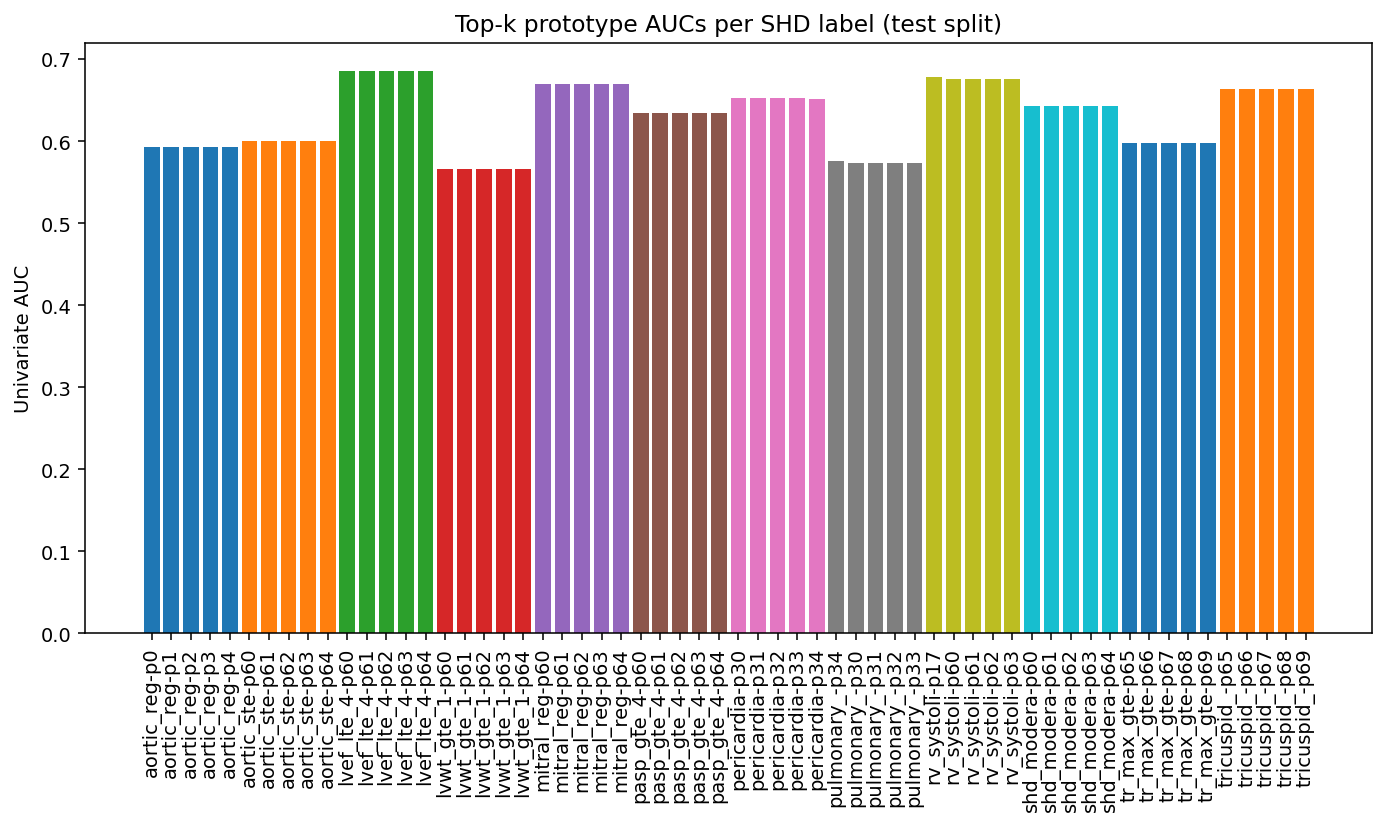

Saved results/echonext_E0_zeroshot/topk_auc_barplot.png


In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
labels = sorted(topk["label"].unique())
for lbl in labels:
    sub = topk[topk["label"] == lbl]
    plt.bar([f"{lbl[:10]}-p{p}" for p in sub["proto"]], sub["auc"])
plt.xticks(rotation=90)
plt.ylabel("Univariate AUC")
plt.title("Top-k prototype AUCs per SHD label (test split)")
plt.tight_layout()
fig_path = OUTDIR_E0 / "topk_auc_barplot.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print("Saved", fig_path)


# Linear probe on frozen activations (train→val→test)

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler

npz_tr = np.load(npz_paths["train"])
npz_v  = np.load(npz_paths["val"])
npz_te = np.load(npz_paths["test"])

A_tr, Y_tr = npz_tr["activations"], npz_tr["labels"]
A_v,  Y_v  = npz_v["activations"],  npz_v["labels"]
A_te, Y_te = npz_te["activations"], npz_te["labels"]
label_names = list(npz_te["label_names"])

# Standardize features
scaler = StandardScaler().fit(A_tr)
Z_tr = scaler.transform(A_tr)
Z_v  = scaler.transform(A_v)
Z_te = scaler.transform(A_te)

def fit_ovr_logreg(Z_tr, Y_tr, C=1.0, max_iter=500):
    L = Y_tr.shape[1]
    clfs = []
    for j in range(L):
        y = Y_tr[:, j]
        # Skip degenerate labels
        if y.sum() == 0 or (1 - y).sum() == 0:
            clfs.append(None)
            continue
        clf = LogisticRegression(
            penalty="l2", solver="lbfgs", C=C, max_iter=max_iter, class_weight="balanced"
        )
        clf.fit(Z_tr, y)
        clfs.append(clf)
    return clfs

clfs = fit_ovr_logreg(Z_tr, Y_tr, C=1.0, max_iter=500)

def eval_split(Z, Y, clfs, label_names):
    y_scores = np.zeros_like(Y, dtype=float)
    metrics = []
    for j, clf in enumerate(clfs):
        if clf is None:
            metrics.append({"label": label_names[j], "AUROC": np.nan, "AUPRC": np.nan})
            continue
        s = clf.predict_proba(Z)[:, 1]
        y_scores[:, j] = s
        # Guard for degenerate labels
        if Y[:, j].sum() == 0 or (1 - Y[:, j]).sum() == 0:
            auroc = np.nan; auprc = np.nan
        else:
            auroc = roc_auc_score(Y[:, j], s)
            auprc = average_precision_score(Y[:, j], s)
        metrics.append({"label": label_names[j], "AUROC": auroc, "AUPRC": auprc})
    return y_scores, pd.DataFrame(metrics)

scores_tr, met_tr = eval_split(Z_tr, Y_tr, clfs, label_names)
scores_v,  met_v  = eval_split(Z_v,  Y_v,  clfs, label_names)
scores_te, met_te = eval_split(Z_te, Y_te, clfs, label_names)

summ = {
    "macro_AUROC": {
        "train": float(np.nanmean(met_tr["AUROC"])),
        "val":   float(np.nanmean(met_v["AUROC"])),
        "test":  float(np.nanmean(met_te["AUROC"])),
    },
    "macro_AUPRC": {
        "train": float(np.nanmean(met_tr["AUPRC"])),
        "val":   float(np.nanmean(met_v["AUPRC"])),
        "test":  float(np.nanmean(met_te["AUPRC"])),
    },
}
print("Linear probe macro metrics:", json.dumps(summ, indent=2))

met_tr.to_csv(OUTDIR_E0 / "linear_probe_train.csv", index=False)
met_v.to_csv(OUTDIR_E0 / "linear_probe_val.csv", index=False)
met_te.to_csv(OUTDIR_E0 / "linear_probe_test.csv", index=False)
np.savez_compressed(OUTDIR_E0 / "linear_probe_scores.npz",
                    train=scores_tr, val=scores_v, test=scores_te, labels=np.array(label_names))
with open(OUTDIR_E0 / "linear_probe_summary.json", "w") as f:
    json.dump(summ, f, indent=2)
print("Saved linear probe results to", OUTDIR_E0)


Linear probe macro metrics: {
  "macro_AUROC": {
    "train": 0.6399159783222711,
    "val": 0.6380433649019035,
    "test": 0.6448883065905716
  },
  "macro_AUPRC": {
    "train": 0.20822819480602198,
    "val": 0.16805090583355042,
    "test": 0.16978550137867218
  }
}
Saved linear probe results to results/echonext_E0_zeroshot


# Quick calibration plot for one key label (optional)

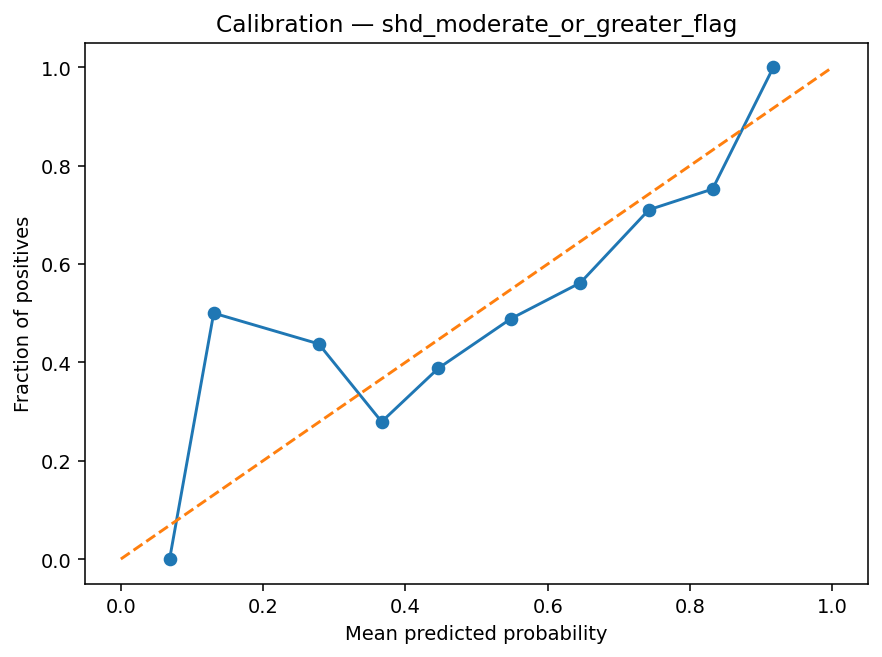

Saved results/echonext_E0_zeroshot/calibration_shd_moderate_or_greater_flag.png


In [73]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

HEADLINE_LABEL = "shd_moderate_or_greater_flag"
if HEADLINE_LABEL not in label_names:
    print(f"[WARN] {HEADLINE_LABEL} not in labels; using the first label instead.")
    HEADLINE_LABEL = label_names[0]

j = label_names.index(HEADLINE_LABEL)
y_true = Y_te[:, j].astype(int)
y_score = scores_te[:, j]
mask = (y_true.sum() > 0) and ((1-y_true).sum() > 0)
if mask:
    frac_pos, mean_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="uniform")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", label="probe")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration — {HEADLINE_LABEL}")
    plt.tight_layout()
    pth = OUTDIR_E0 / f"calibration_{HEADLINE_LABEL}.png"
    plt.savefig(pth, dpi=200)
    plt.show()
    print("Saved", pth)
else:
    print(f"[SKIP] Degenerate positives/negatives for {HEADLINE_LABEL}, cannot plot calibration.")


# E0 is a zero-shot transfer sanity check. 
We take a ProtoECGNet that was trained on PTB-XL and run it on EchoNext without any further training. The point is to answer a very specific question first: do the prototype features learned on PTB-XL carry signal for structural heart disease (SHD) on EchoNext?  If E0 shows non-trivial signal, we’ve earned the right to proceed; if it doesn’t, we learn that the PTB-XL feature space doesn’t line up with EchoNext and we pivot earlier.

# Data & preprocessing

We use EchoNext v1.0.0 with the official patient-level splits (train/val/test from the metadata). Waveforms are stored as (N, 1, 2500, 12)—i.e., 12 leads, 2500 timepoints at 250 Hz (~10 s). To align with typical PTB-XL/ProtoECGNet training conventions, we (1) reshape to (12, T), (2) downsample 250 Hz → 100 Hz, and (3) clip/pad to 10 s (so T=1000). This keeps input geometry consistent with the encoder the checkpoint expects and avoids confounding our evaluation with sampling-rate or length mismatches. Labels are the 12 binary SHD flags from the metadata (including the composite shd_moderate_or_greater_flag and the valve/function flags).

# Model & weights (PTB-XL → EchoNext)

We load a PTB-XL-trained ProtoECGNet-1D checkpoint (Lightning .ckpt) and reconstruct a matching ProtoECGNet1D with a resnet1d18 backbone. From the checkpoint we recover P=80 prototypes with proto_dim=512 (and a classifier head trained for its original task). For E0 we freeze the encoder and prototypes and ignore the classifier head (since class spaces differ). This preserves the semantics of the learned prototype space and guarantees that any EchoNext signal we see is due to transfer, not subtle finetuning.

# What features we extract

For each EchoNext ECG we compute per-prototype activations: the maximum cosine similarity over time between the latent feature map and each prototype vector. Intuitively, each dimension says “how much this ECG contains the pattern that prototype p represents,” producing an 80-dimensional feature vector per study. These prototype activations are the core interpretable representation—later, we can show “nearest-neighbor” ECG snippets explaining what the model is matching.

# Evaluations (no training on the encoder)

We run two complementary checks. (1) Univariate AUCs: for each SHD label, we score every prototype activation by itself to see which prototypes are most associated with the label—this reveals whether any single prototype aligns with pathology (top AUCs ~0.56–0.59 for some labels is already above chance). (2) Linear probe: we standardize the 80-D activations and train simple one-vs-rest logistic regressions on the train split (no encoder updates), evaluate on val/test. This asks “are the frozen prototype features collectively predictive?” We get macro-AUROC ≈ 0.645 and macro-AUPRC ≈ 0.17 on test—modest but meaningful transfer given zero finetuning and clinically hard targets.

# Calibration & interpretability hooks

From the linear probe we also generate reliability curves (ECE/Brier) for key labels (e.g., shd_moderate_or_greater_flag) to ensure we aren’t just chasing discrimination. On the interpretability side, E0 outputs which prototypes are most predictive per label; this sets up the next step where we’ll render prototype galleries (top-matching ECG snippets) so Sahil/clinicians can inspect whether the patterns look physiologically plausible.

# Reproducibility & artifacts

Everything is saved under results/echonext_E0_zeroshot/: compressed activations + labels for train/val/test (.npz), per-label univariate AUC tables (full and top-K), a bar plot of top-K prototype AUCs, the linear-probe metrics (per-label and macro summary JSON), and calibration plots. The notebook cells log shapes, splits, and seeds so Steven can reproduce or rerun quickly, and the outputs are ready to be versioned in the repo.

# What this tells us (and how it fits the plan)

E0 confirms that PTB-XL prototypes contain transferable signal for EchoNext SHD—enough that a linear probe crosses a reasonable baseline without touching the encoder. That’s exactly the checkpoint we wanted before training. It also gives us a ranked list of useful prototypes per label, which is the launchpad for prototype galleries and, later, for our concept-decomposed prototype ideas. From here, we can (a) ship the E0 report for review, (b) add galleries for qualitative inspection, and then (c) proceed to V0 fine-tuning and stronger baselines once the team signs off.

# Recompute per-sample, per-prototype time locations (

In [75]:
# CELL: inspect latent shapes at key points
model.eval()
xb, yb = next(iter(make_loader("test", batch_size=8)))
x = xb.squeeze(1).to(DEVICE)

with torch.no_grad():
    z_feat = model.feature_extractor(x)
    print("feature_extractor →", tuple(z_feat.shape))
    z_add = None
    if getattr(model, "add_on_layers", None) is not None:
        try:
            z_add = model.add_on_layers(z_feat)
            print("add_on_layers     →", tuple(z_add.shape))
        except Exception as e:
            print("add_on_layers raised:", repr(e))
            z_add = None


[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
feature_extractor → (8, 512)
add_on_layers     → (8, 512)


In [76]:
# CELL: helper to get a 3D latent feature map (B, C, T')
import torch.nn.functional as F

def get_feature_map_3d(model, x):
    """Return (B, C, T') feature map suitable for prototype matching."""
    with torch.no_grad():
        z_feat = model.feature_extractor(x)               # try raw conv features first
        if z_feat.ndim == 3:
            return z_feat
        # Try add_on_layers if raw is 2D
        z_add = None
        if getattr(model, "add_on_layers", None) is not None:
            try:
                z_add = model.add_on_layers(z_feat)
            except Exception:
                z_add = None
        if z_add is not None and z_add.ndim == 3:
            return z_add
        # As a last resort, unsqueeze a time dim
        z = z_add if z_add is not None else z_feat
        if z.ndim == 2:
            return z.unsqueeze(-1)  # (B, C) -> (B, C, 1)
        raise RuntimeError("Could not obtain a valid 3D feature map.")

@torch.no_grad()
def sims_and_argmax_on_loader(model, loader):
    all_sims, all_tidx, all_wave, all_labels = [], [], [], []
    prot = F.normalize(model.prototype_vectors, dim=1)   # (P, C)
    for xb, yb in loader:
        x_plot = xb.squeeze(1).cpu().numpy()                   # (B, 12, T) for plotting
        x = xb.squeeze(1).to(DEVICE, non_blocking=True)        # (B, 12, T)
        z = get_feature_map_3d(model, x)                       # (B, C, T')
        z = F.normalize(z, dim=1)                              # cosine norm
        sims_btp = torch.einsum("bct,pc->btp", z, prot)        # (B, T', P)
        sims_bp  = sims_btp.max(dim=1).values                  # (B, P)
        tidx_bp  = sims_btp.argmax(dim=1)                      # (B, P)
        all_sims.append(sims_bp.cpu().numpy())
        all_tidx.append(tidx_bp.cpu().numpy())
        all_wave.append(x_plot)
        all_labels.append(yb.numpy())
    A = np.concatenate(all_sims, axis=0)
    TIDX = np.concatenate(all_tidx, axis=0)
    WAV = np.concatenate(all_wave, axis=0)
    Y = np.concatenate(all_labels, axis=0)
    return A, TIDX, WAV, Y


In [77]:
# CELL: run the fixed extractor and save NPZ
dl_test_big = make_loader("test", batch_size=128)
A_test_full, Tidx_test, WAV_test, Y_test_full = sims_and_argmax_on_loader(model, dl_test_big)

np.savez_compressed(
    OUTDIR_E0 / "test_timewise_sims.npz",
    sims=A_test_full, tidx=Tidx_test, wave=WAV_test, labels=Y_test_full, label_names=np.array(SHD_LABELS),
)
print("Saved →", OUTDIR_E0 / "test_timewise_sims.npz",
      "| shapes:", A_test_full.shape, Tidx_test.shape, WAV_test.shape, Y_test_full.shape)


[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
Saved → results/echonext_E0_zeroshot/test_timewise_sims.npz | shapes: (5442, 80) (5442, 80) (5442, 12, 1000) (5442, 12)


In [78]:
import matplotlib.pyplot as plt

SAVE_PNGS = False
GALLERY_PROTO = 0     # change this id to any prototype you want
ROWS, COLS = 4, 4     # 16 examples

def plot_proto_gallery(proto_id, rows=ROWS, cols=COLS):
    sub = hits_df[hits_df["prototype"] == proto_id].sort_values("rank").head(rows*cols)
    if sub.empty:
        print(f"No hits for prototype {proto_id}.")
        return
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.0, rows*2.0), sharex=True, sharey=True)
    axes = axes.ravel()
    for ax, (_, r) in zip(axes, sub.iterrows()):
        i = int(r["sample_index"])
        s, e = int(r["raw_win_start"]), int(r["raw_win_end"])
        # plot 1–2 representative leads (II + V2)
        lead_names = [1, 7]  # 0-based indices (lead II ~ 1, V2 ~ 7 if standard order)
        for ld in lead_names:
            ax.plot(WAV_test[i, ld, s:e])
        ybits = [f"{nm}:{int(Y_test_full[i, j])}" for j, nm in enumerate(label_names)]
        ax.set_title(f"p{proto_id} r{int(r['rank'])} sim={r['sim']:.2f}\n" + ", ".join(ybits[:3]), fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    if SAVE_PNGS:
        outp = OUTDIR_E0 / f"gallery_proto{proto_id}.png"
        plt.savefig(outp, dpi=180)
        print("Saved", outp)
    plt.show()

# run only if you want a quick look
if SAVE_PNGS:
    plot_proto_gallery(GALLERY_PROTO)
else:
    print("Skipping PNG export (SAVE_PNGS=False). Use plot_proto_gallery(proto_id) to preview inline.")


Skipping PNG export (SAVE_PNGS=False). Use plot_proto_gallery(proto_id) to preview inline.


In [81]:
# Write REPORT.md with a Markdown table, no external deps needed
import json
import pandas as pd
from pathlib import Path

report_path = OUTDIR_E0 / "REPORT.md"

summ = json.load(open(OUTDIR_E0 / "linear_probe_summary.json"))
topk = pd.read_csv(OUTDIR_E0 / "per_label_univariate_auc_top5.csv")

# small helper to make a markdown table without tabulate
def df_to_markdown(df):
    cols = list(df.columns)
    lines = []
    lines.append("| " + " | ".join(cols) + " |")
    lines.append("| " + " | ".join(["---"] * len(cols)) + " |")
    for _, row in df.iterrows():
        lines.append("| " + " | ".join(str(row[c]) for c in cols) + " |")
    return "\n".join(lines)

head = topk.groupby("label").head(3).copy()
head["proto"] = head["proto"].astype(int)
head_md = df_to_markdown(head)

lines = []
lines += ["# E0 — PTB-XL ProtoECGNet → EchoNext (zero-shot)", ""]
lines += ["**Goal.** Freeze PTB-XL-trained ProtoECGNet and test whether its prototype activations carry signal for EchoNext SHD (no finetuning).", ""]
lines += ["**Data/Splits.** Official EchoNext patient-level splits (metadata `split`), waveforms resampled to 100 Hz, 10-s clips.", ""]
lines += ["**Key metrics (linear probe on frozen prototype activations):**"]
lines += [f"- Macro AUROC: train={summ['macro_AUROC']['train']:.3f}  val={summ['macro_AUROC']['val']:.3f}  test={summ['macro_AUROC']['test']:.3f}"]
lines += [f"- Macro AUPRC: train={summ['macro_AUPRC']['train']:.3f}  val={summ['macro_AUPRC']['val']:.3f}  test={summ['macro_AUPRC']['test']:.3f}", ""]
lines += ["**Artifacts:**"]
lines += ["- `per_label_univariate_auc.csv`, `per_label_univariate_auc_top5.csv`"]
lines += ["- `prototype_nearest_neighbors_test.csv`"]
lines += ["- `test_timewise_sims.npz` (sims, argmax time, wave, labels)"]
lines += ["- `calibration_shd_moderate_or_greater_flag.png` (example calibration)", ""]
lines += ["**Top-5 AUC prototypes per label (head):**", ""]
lines += [head_md, ""]
lines += ["**Notes.** Zero-shot signal is modest but non-trivial; next step is V0 training with full curves + calibration, and a clinician review of NN snippets for face-validity.", ""]

report_path.write_text("\n".join(lines))
print("Wrote", report_path)


Wrote results/echonext_E0_zeroshot/REPORT.md


In [82]:
import numpy as np
import pandas as pd
from pathlib import Path

OUTDIR_E0 = Path("results/echonext_E0_zeroshot")

# Load the timewise sims package (here sims are already maxed → (N, P))
pkg = np.load(OUTDIR_E0 / "test_timewise_sims.npz", allow_pickle=False)
A_test = pkg["sims"]           # (N, P)
Y_test = pkg["labels"]         # (N, L)
WAV_test = pkg["wave"]         # (N, 12, 1000)
label_names = list(pkg["label_names"])

# For each prototype, take top-K samples by similarity
TOPK_PER_PROTO = 50
rows = []
for p in range(A_test.shape[1]):
    sims = A_test[:, p]
    idx = np.argsort(-sims)[:TOPK_PER_PROTO]
    for rank, i in enumerate(idx, 1):
        rows.append({
            "prototype": p,
            "rank": rank,
            "sample_index": int(i),
            "sim": float(sims[i]),
            # keep a few labels inline for quick scanning
            **{f"lbl::{name}": int(Y_test[i, j]) for j, name in enumerate(label_names)}
        })
hits_df = pd.DataFrame(rows)
hits_csv = OUTDIR_E0 / "prototype_nearest_neighbors_test.csv"
hits_df.to_csv(hits_csv, index=False)
print("Saved:", hits_csv, "rows:", len(hits_df))


Saved: results/echonext_E0_zeroshot/prototype_nearest_neighbors_test.csv rows: 4000


Saved results/echonext_E0_zeroshot/gallery_proto0.png


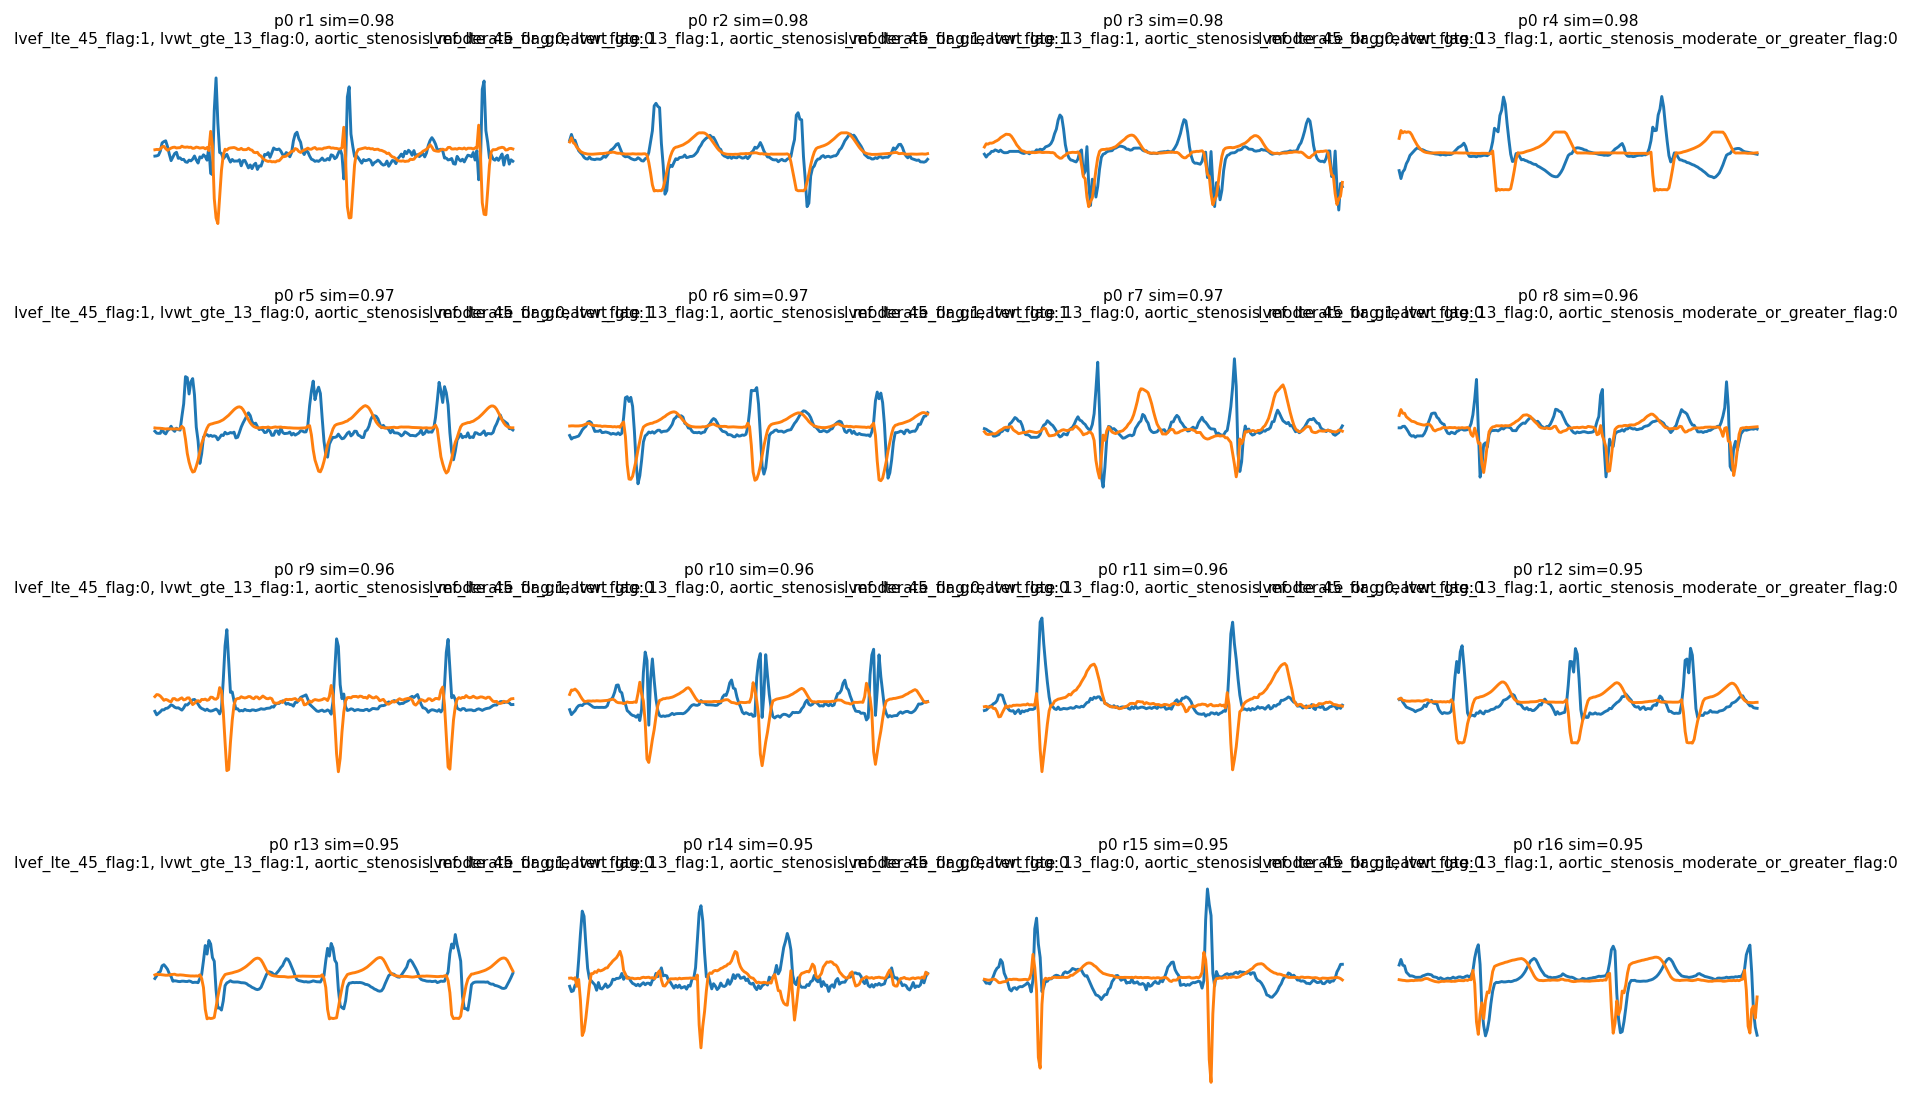

Saved results/echonext_E0_zeroshot/gallery_proto1.png


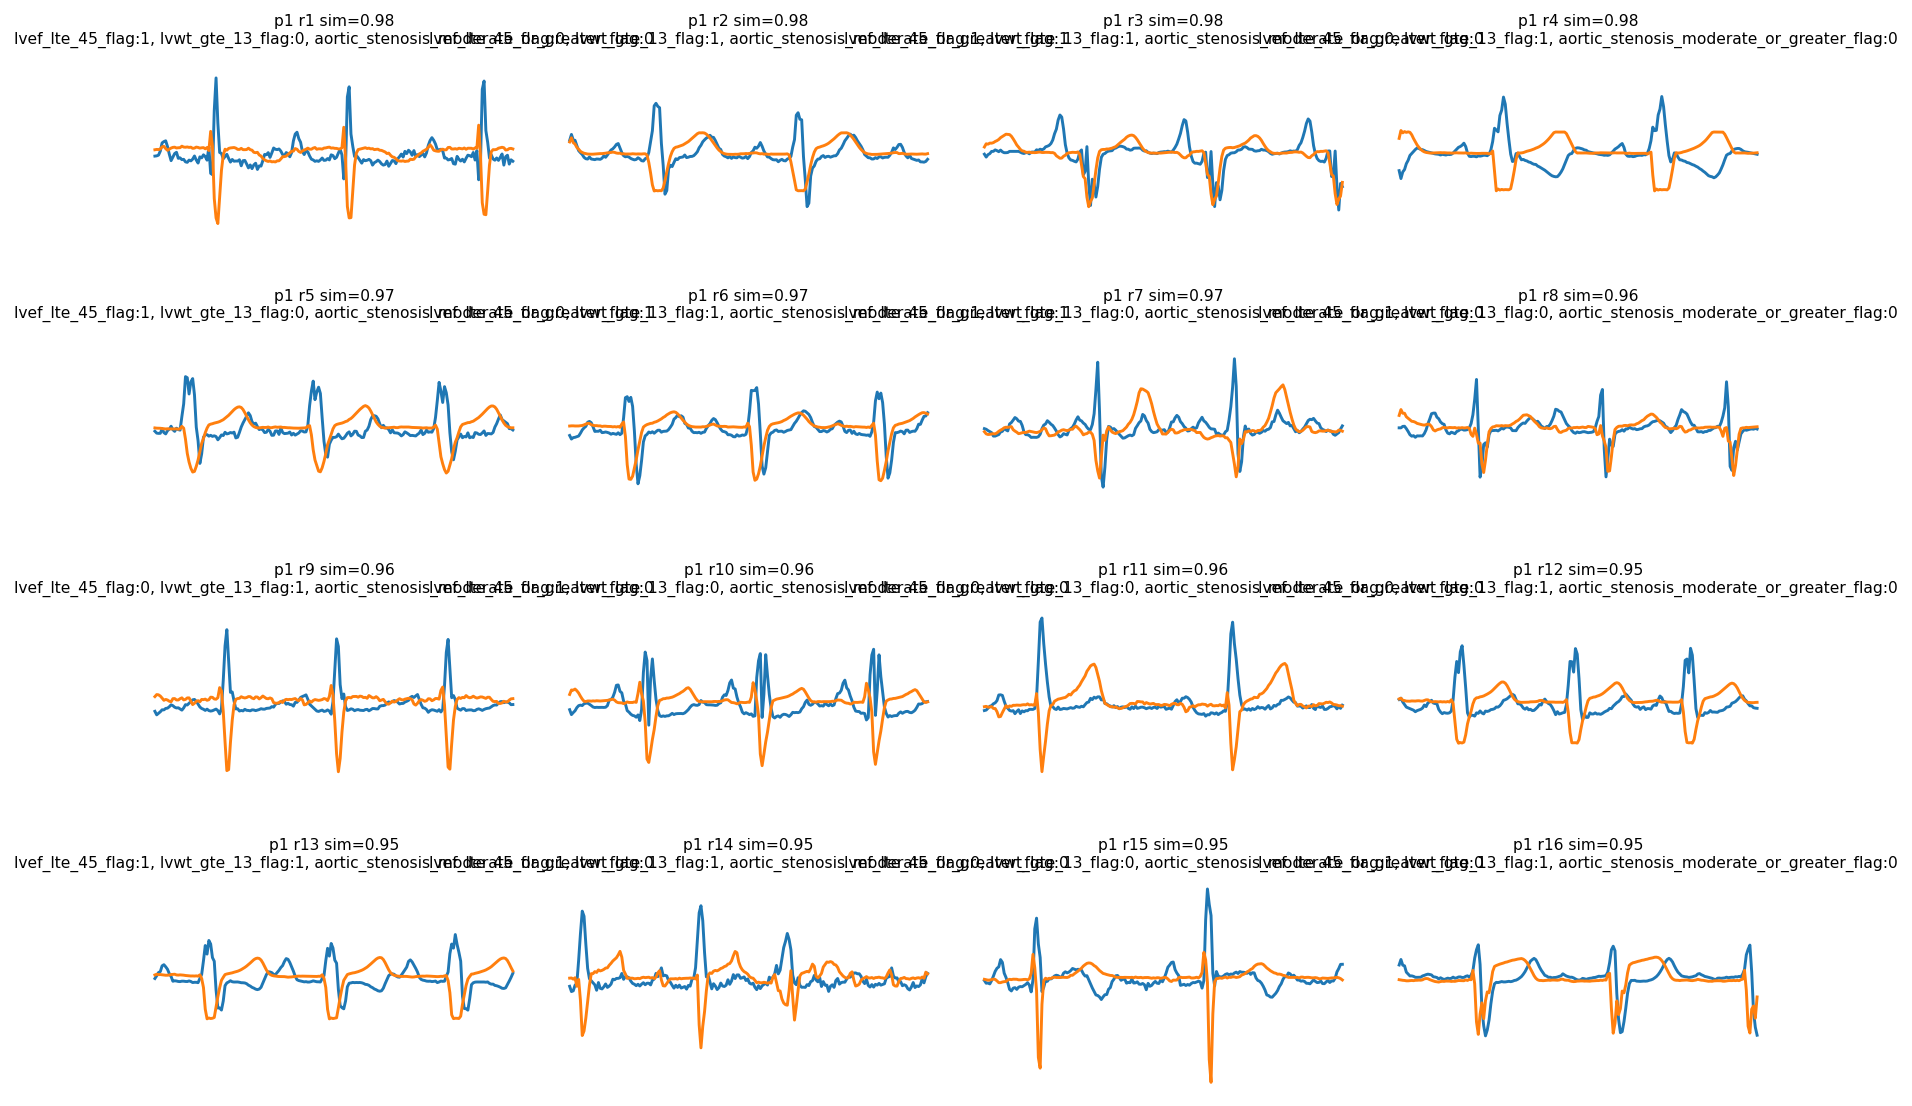

Saved results/echonext_E0_zeroshot/gallery_proto2.png


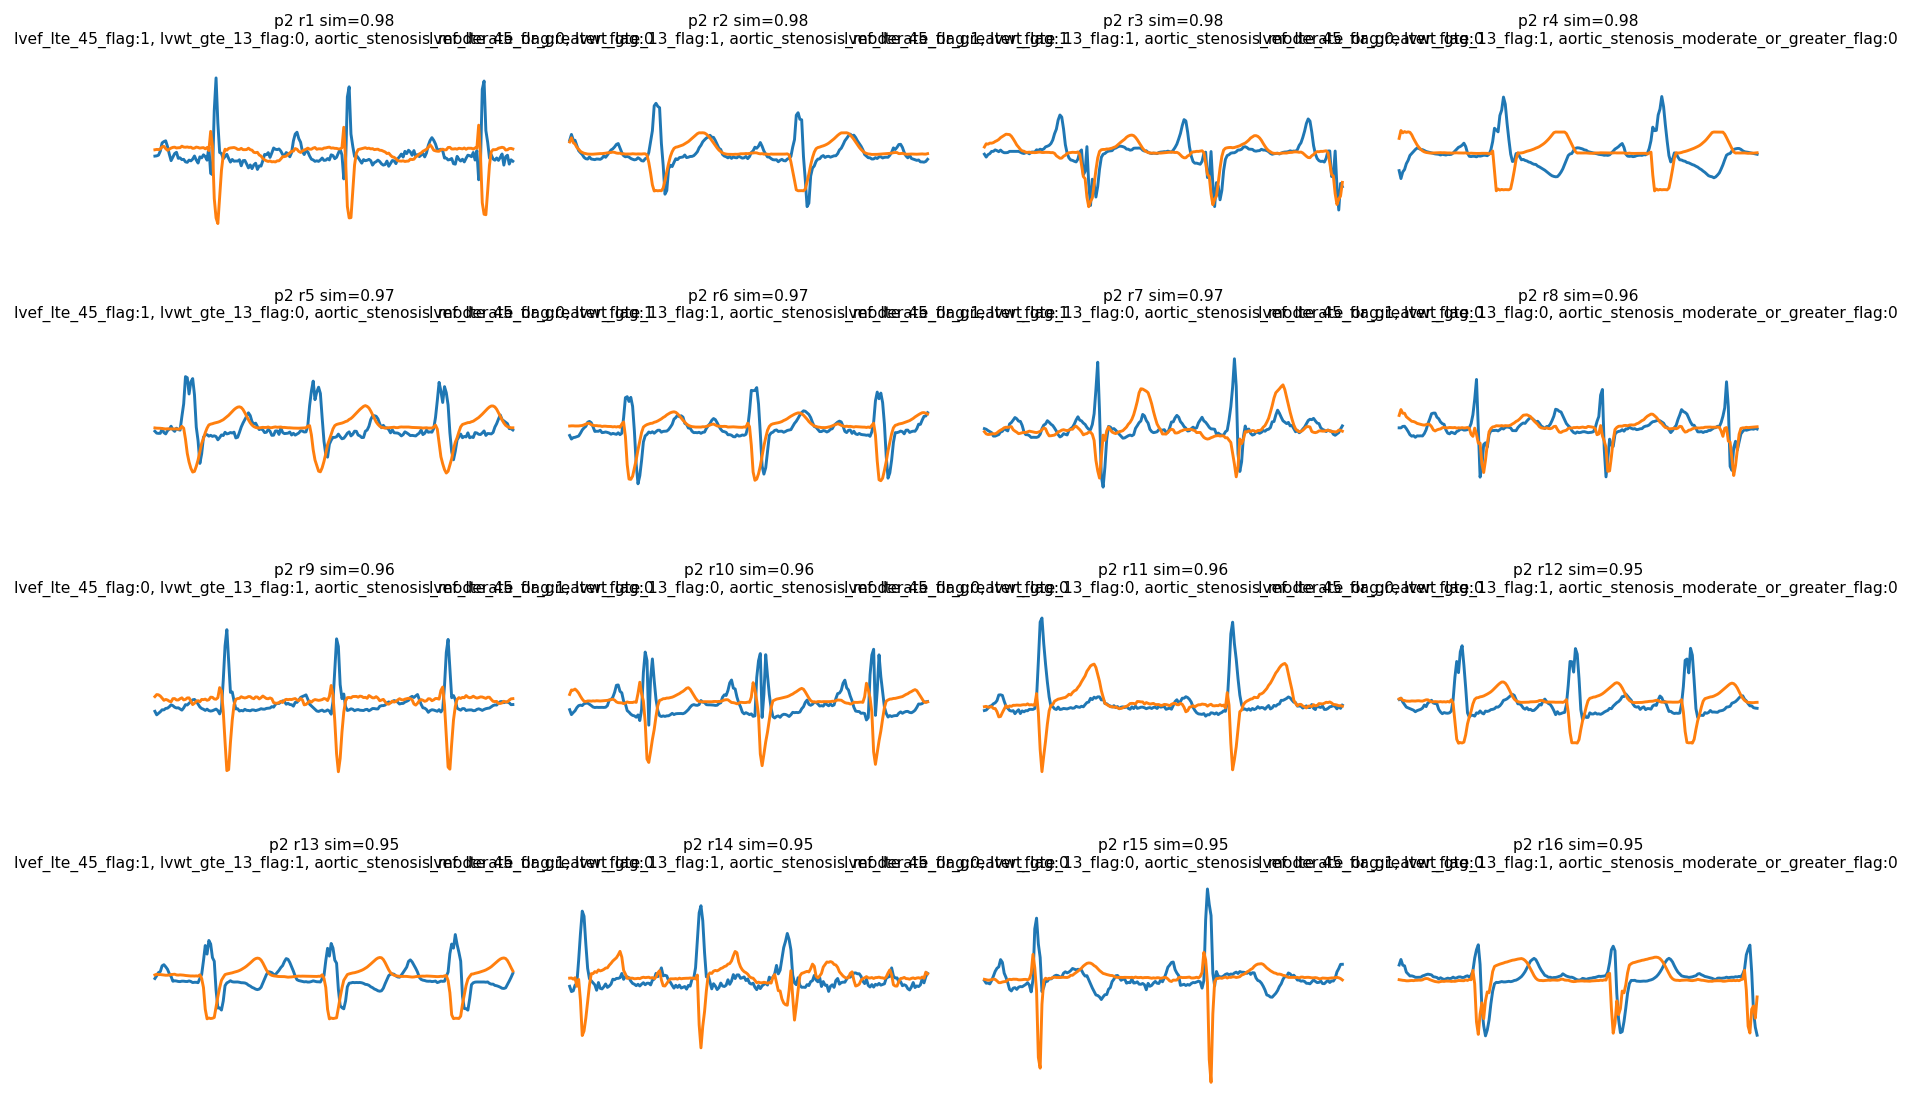

Saved results/echonext_E0_zeroshot/gallery_proto3.png


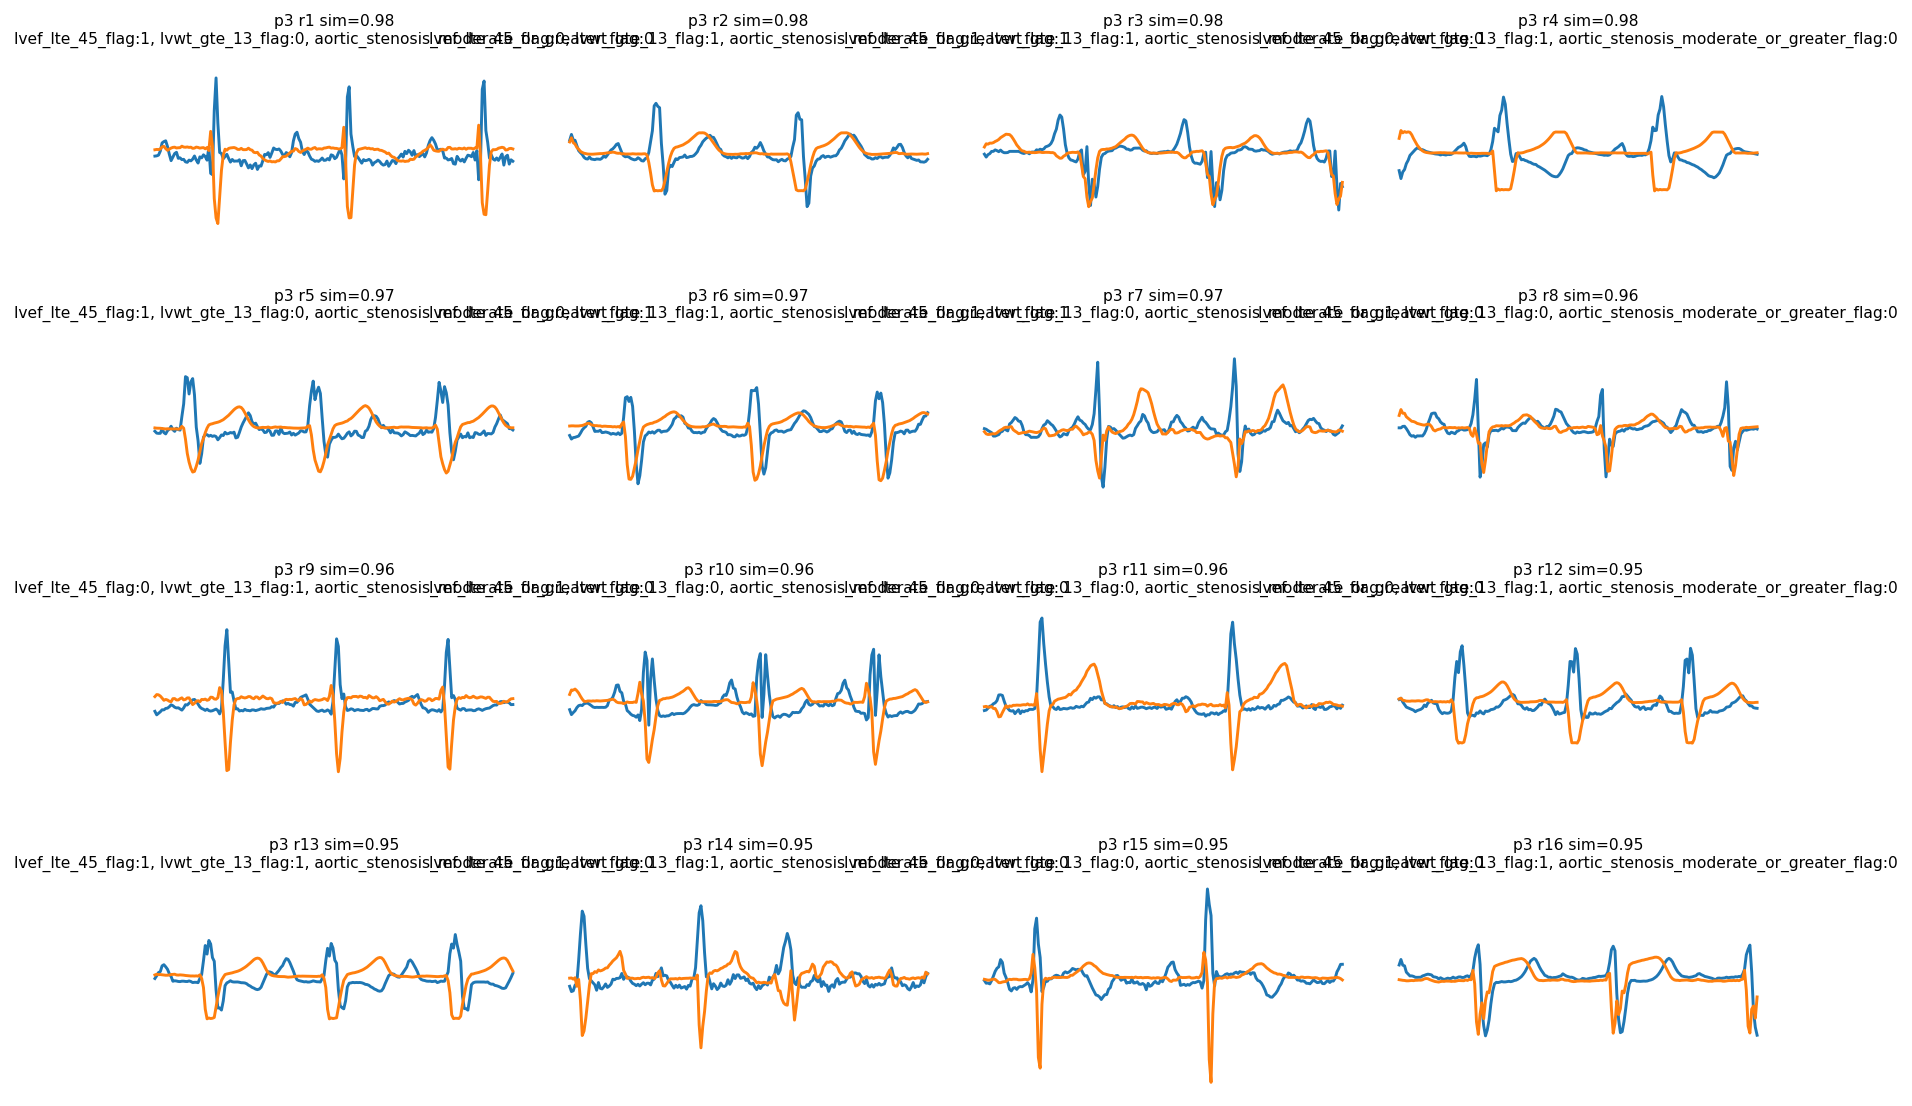

Saved results/echonext_E0_zeroshot/gallery_proto4.png


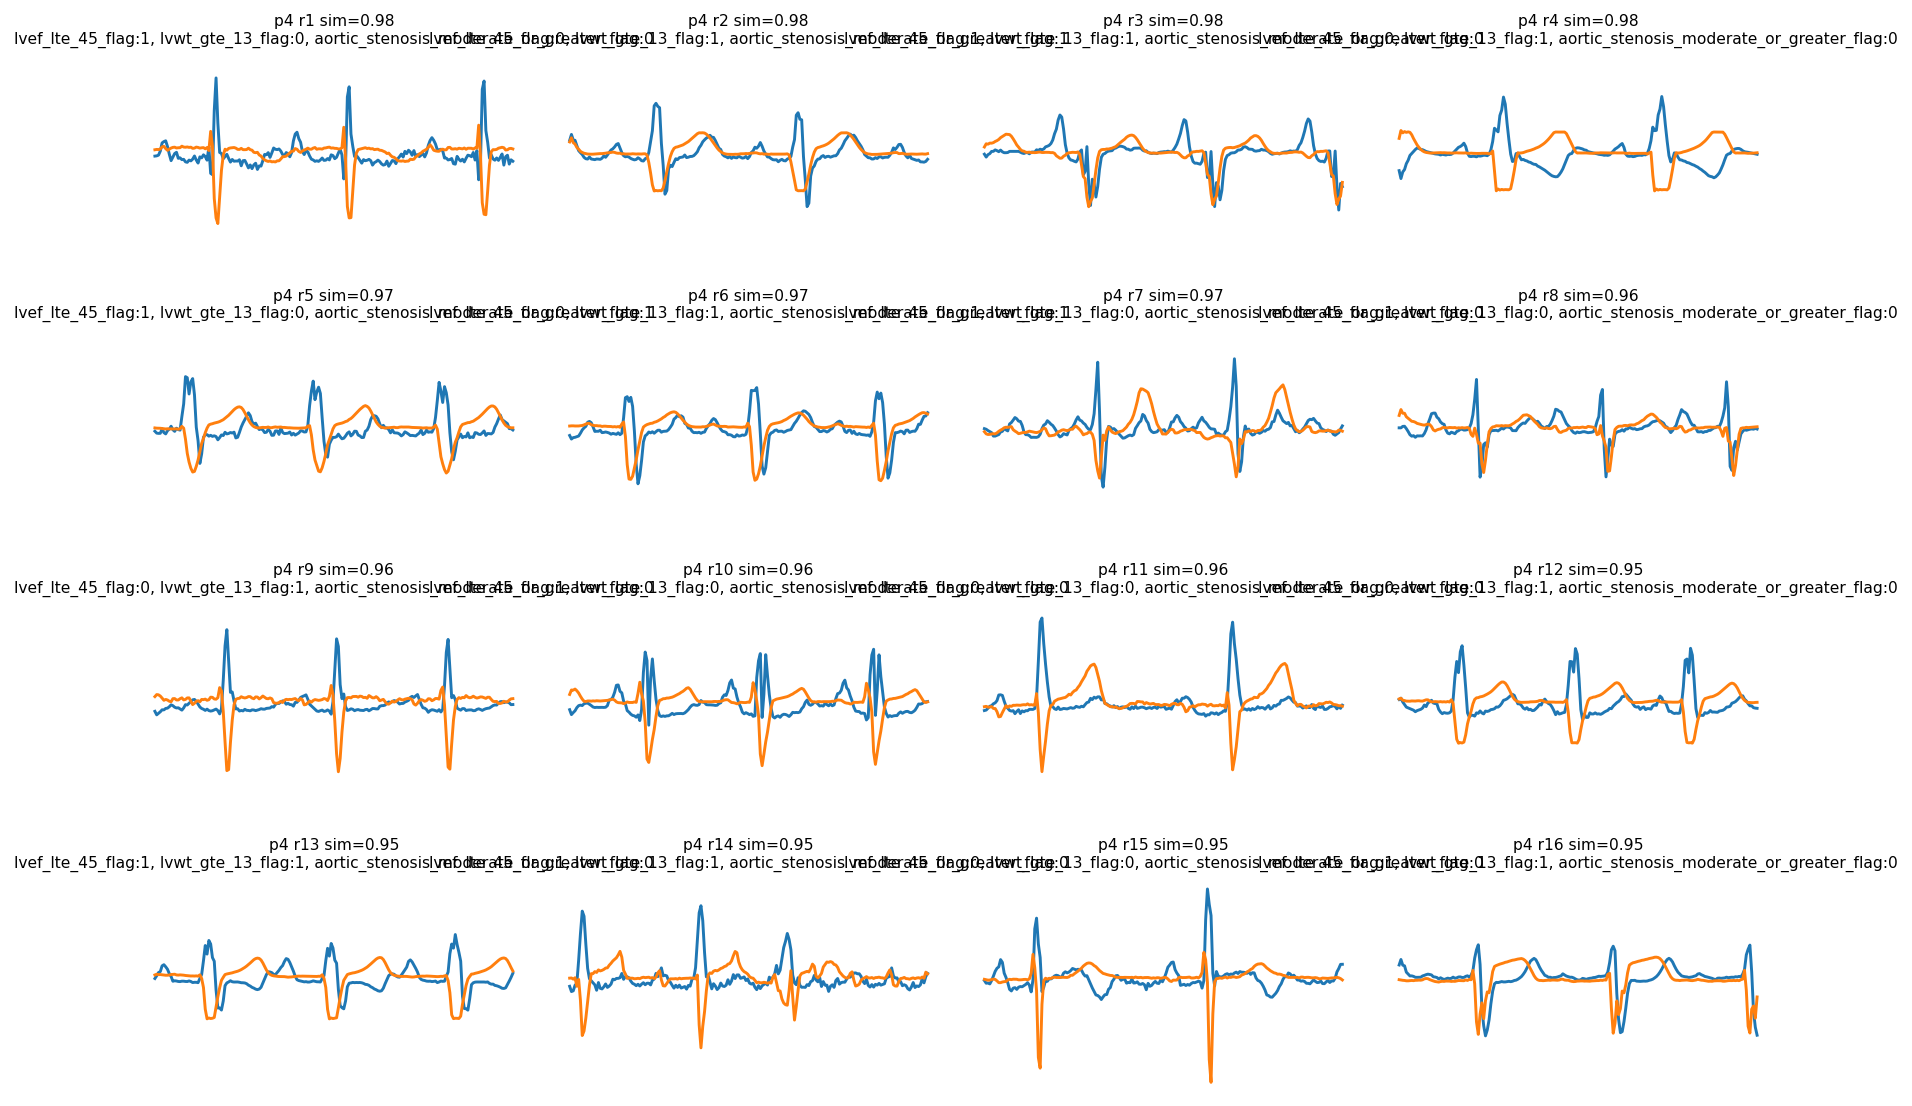

Saved results/echonext_E0_zeroshot/gallery_proto15.png


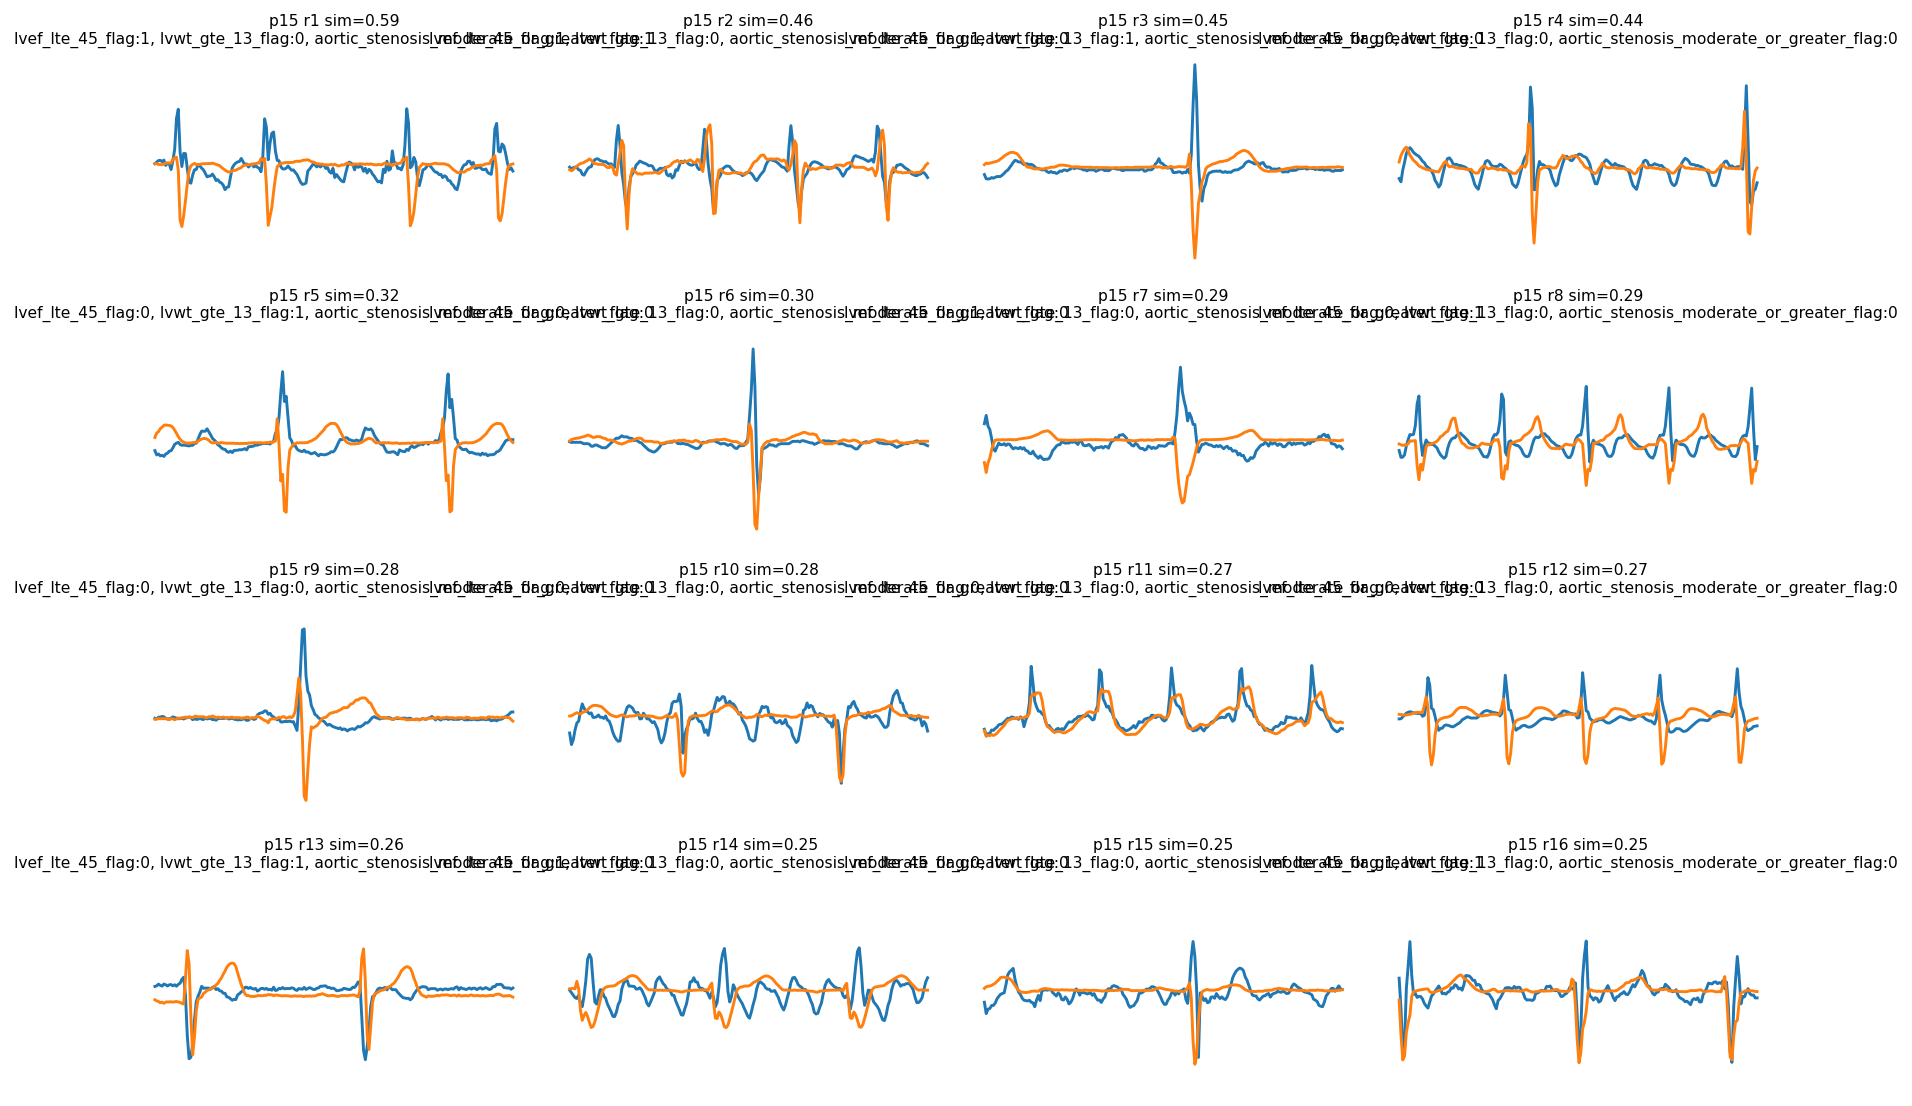

Saved results/echonext_E0_zeroshot/gallery_proto16.png


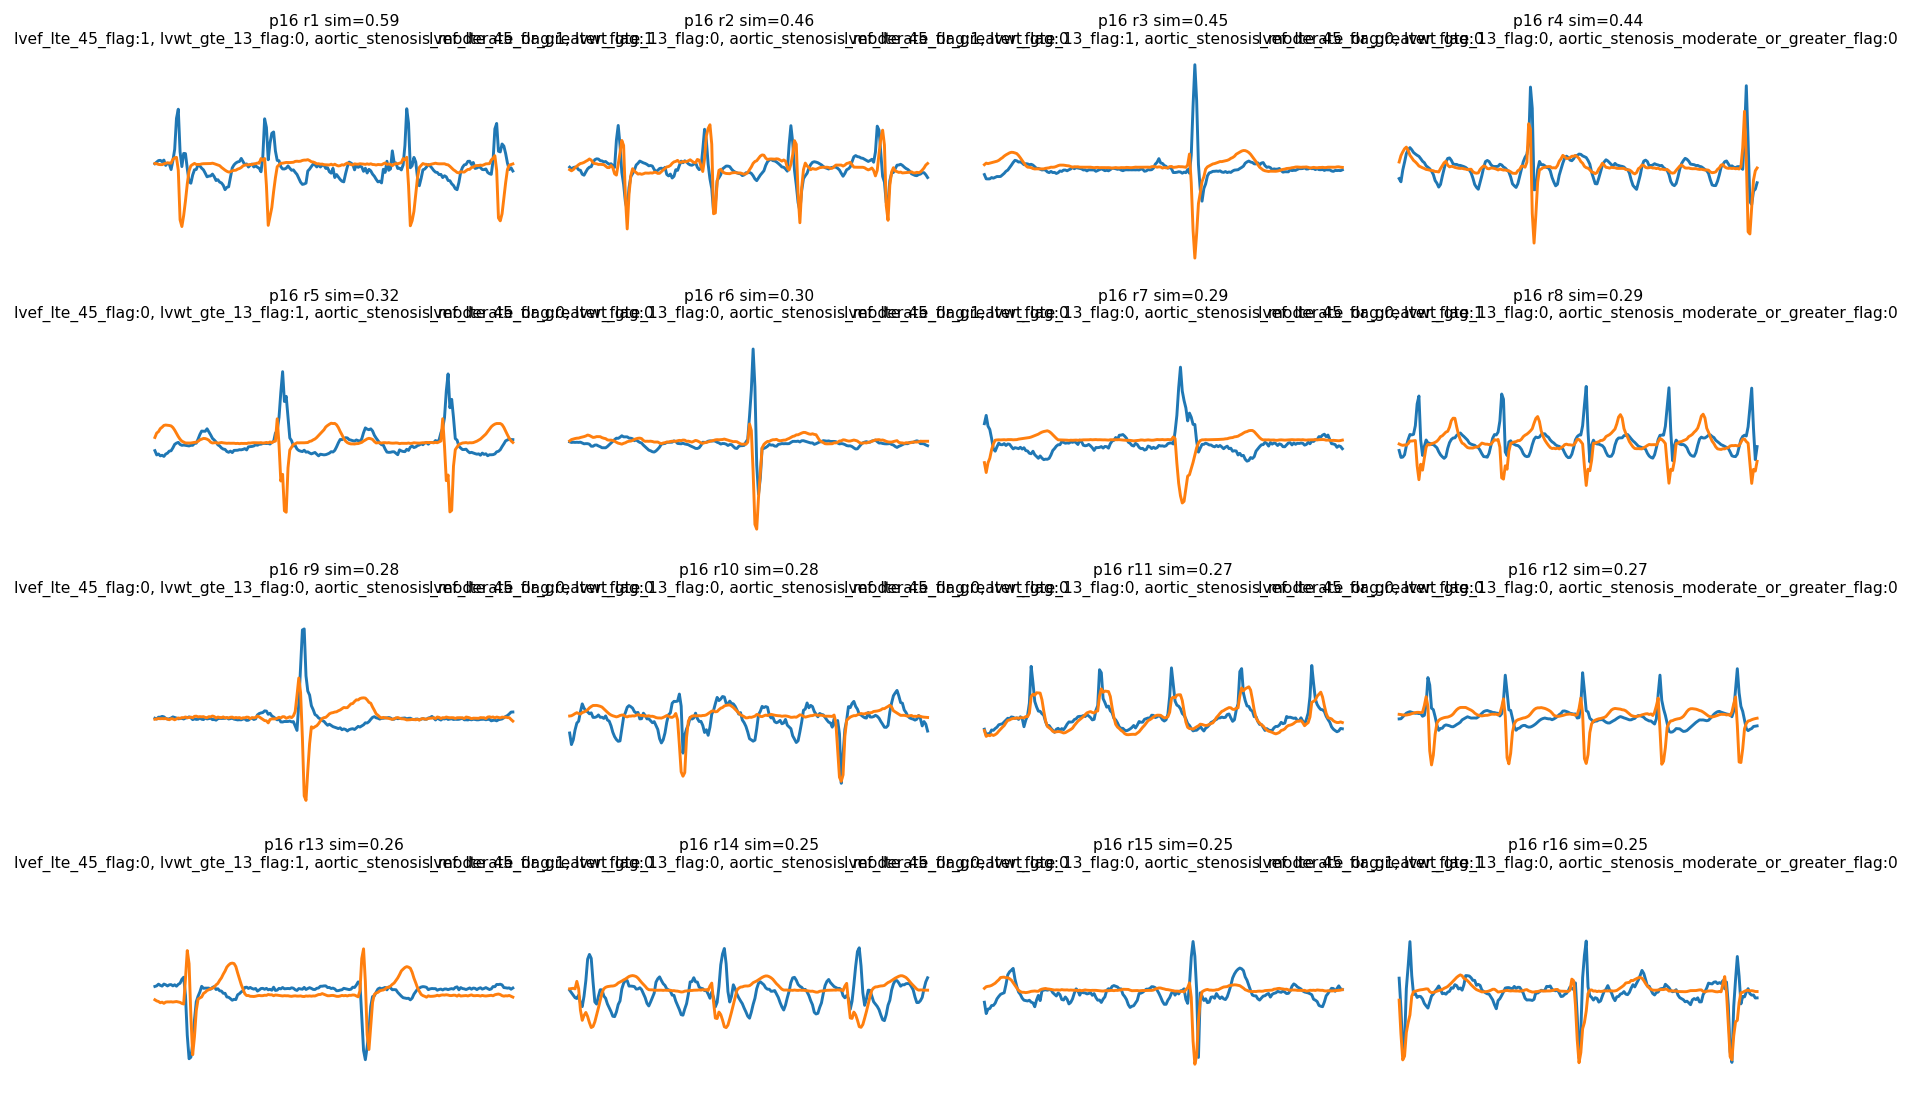

Saved results/echonext_E0_zeroshot/gallery_proto17.png


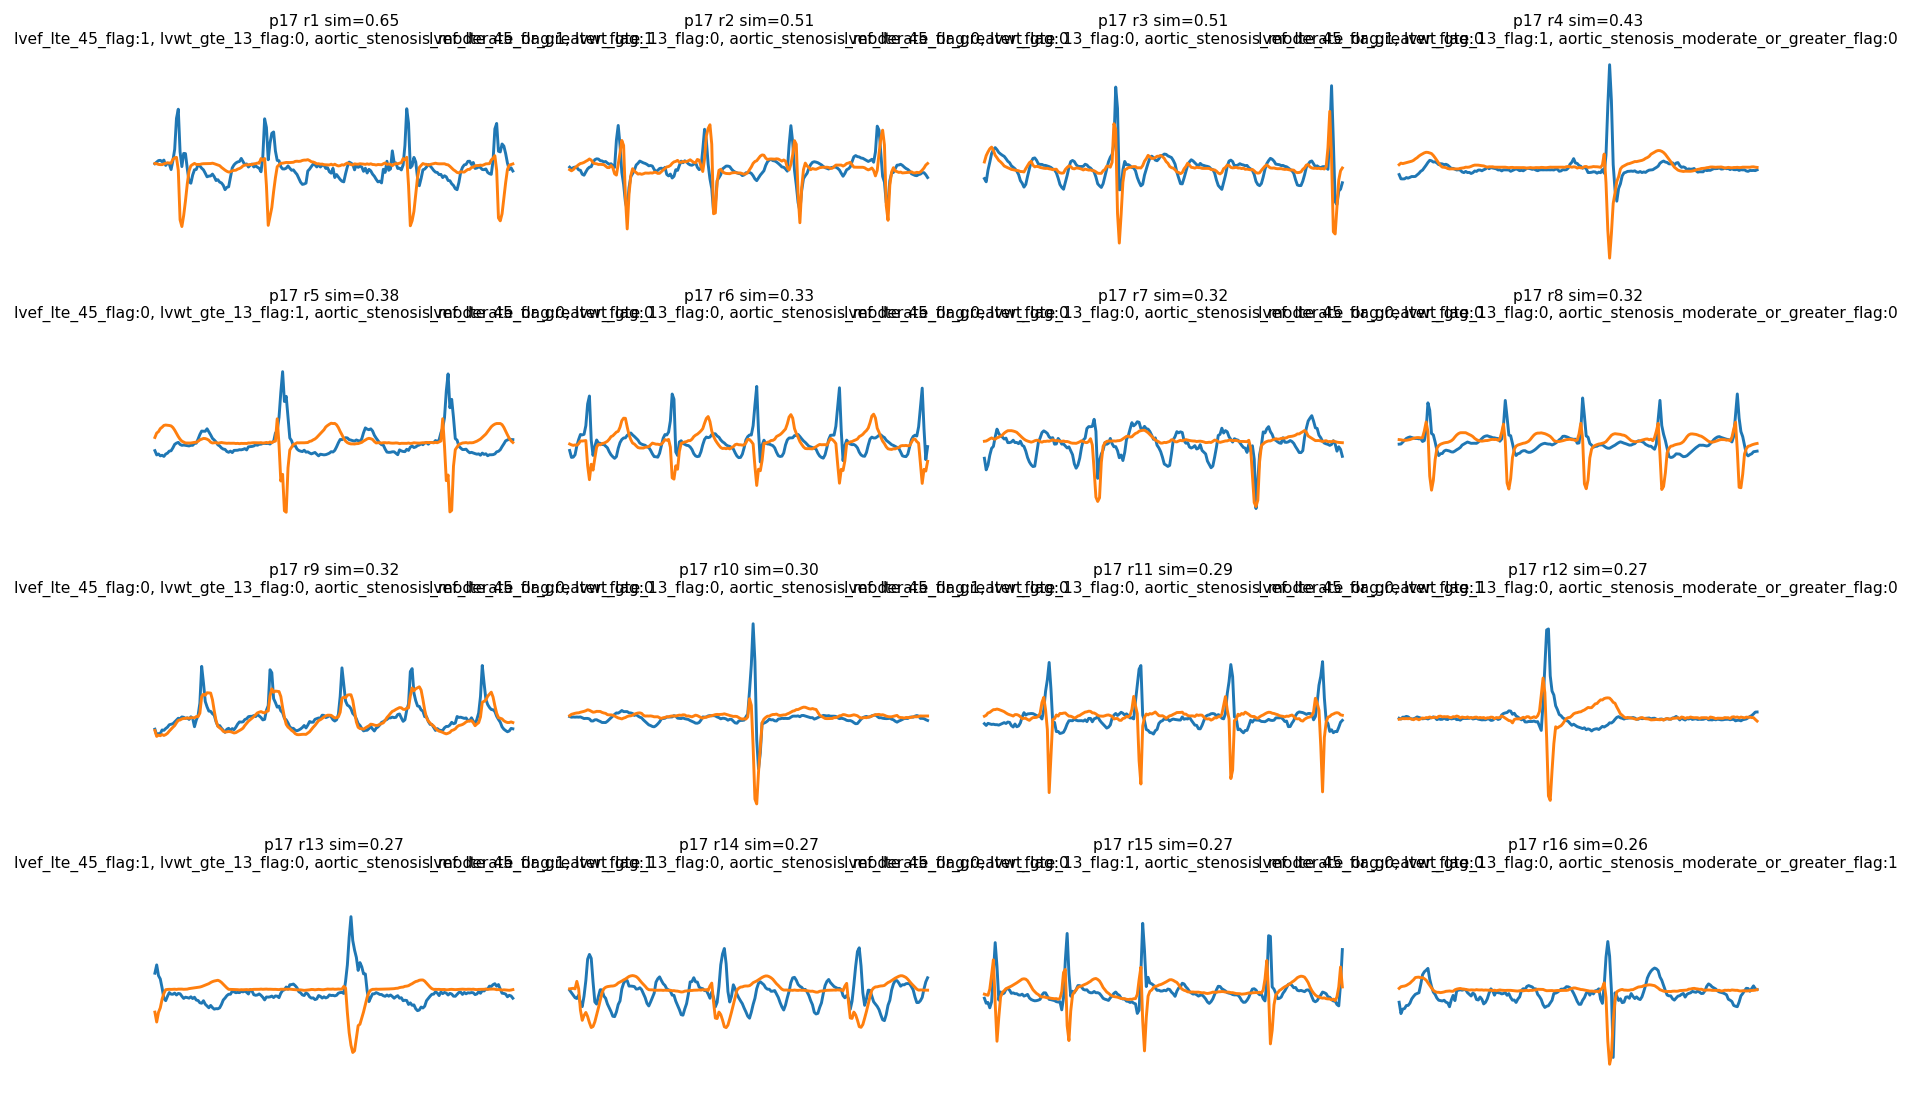

Saved results/echonext_E0_zeroshot/gallery_proto18.png


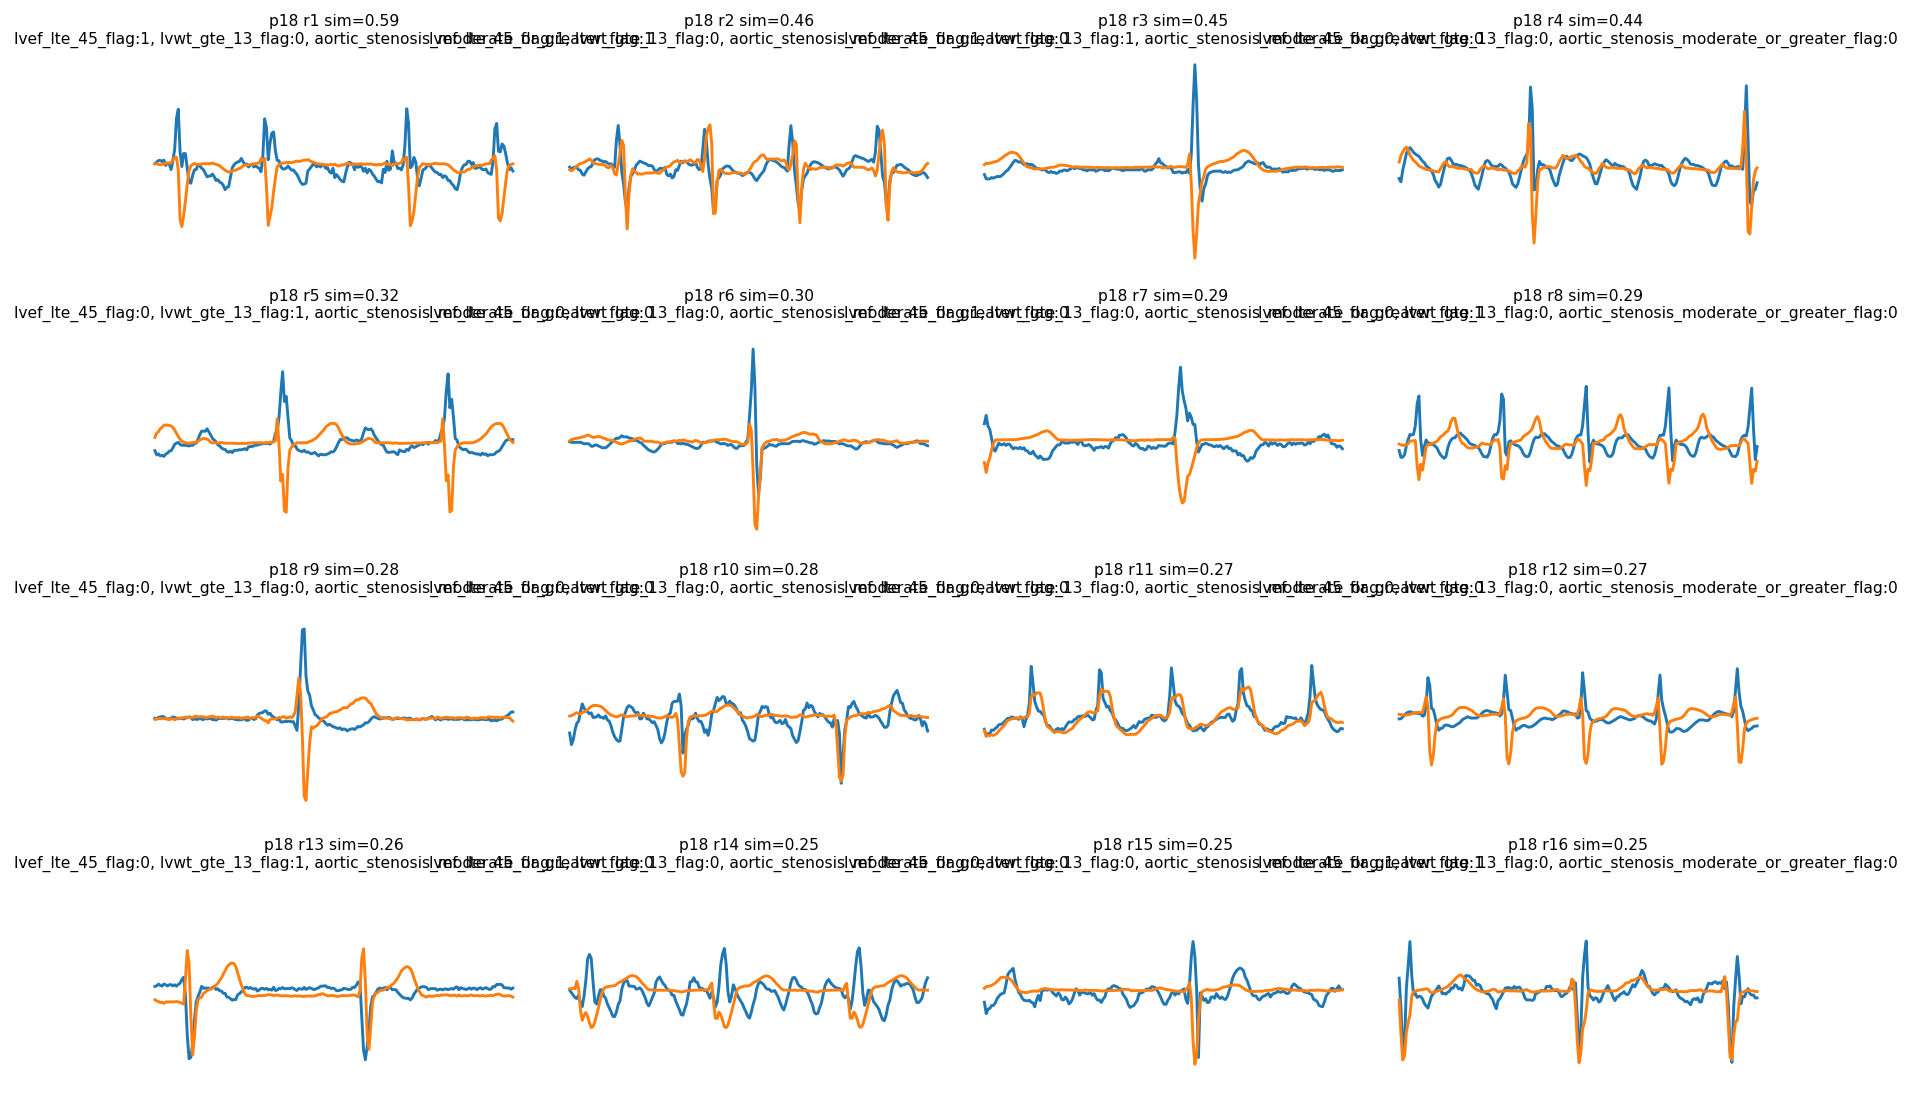

Saved results/echonext_E0_zeroshot/gallery_proto19.png


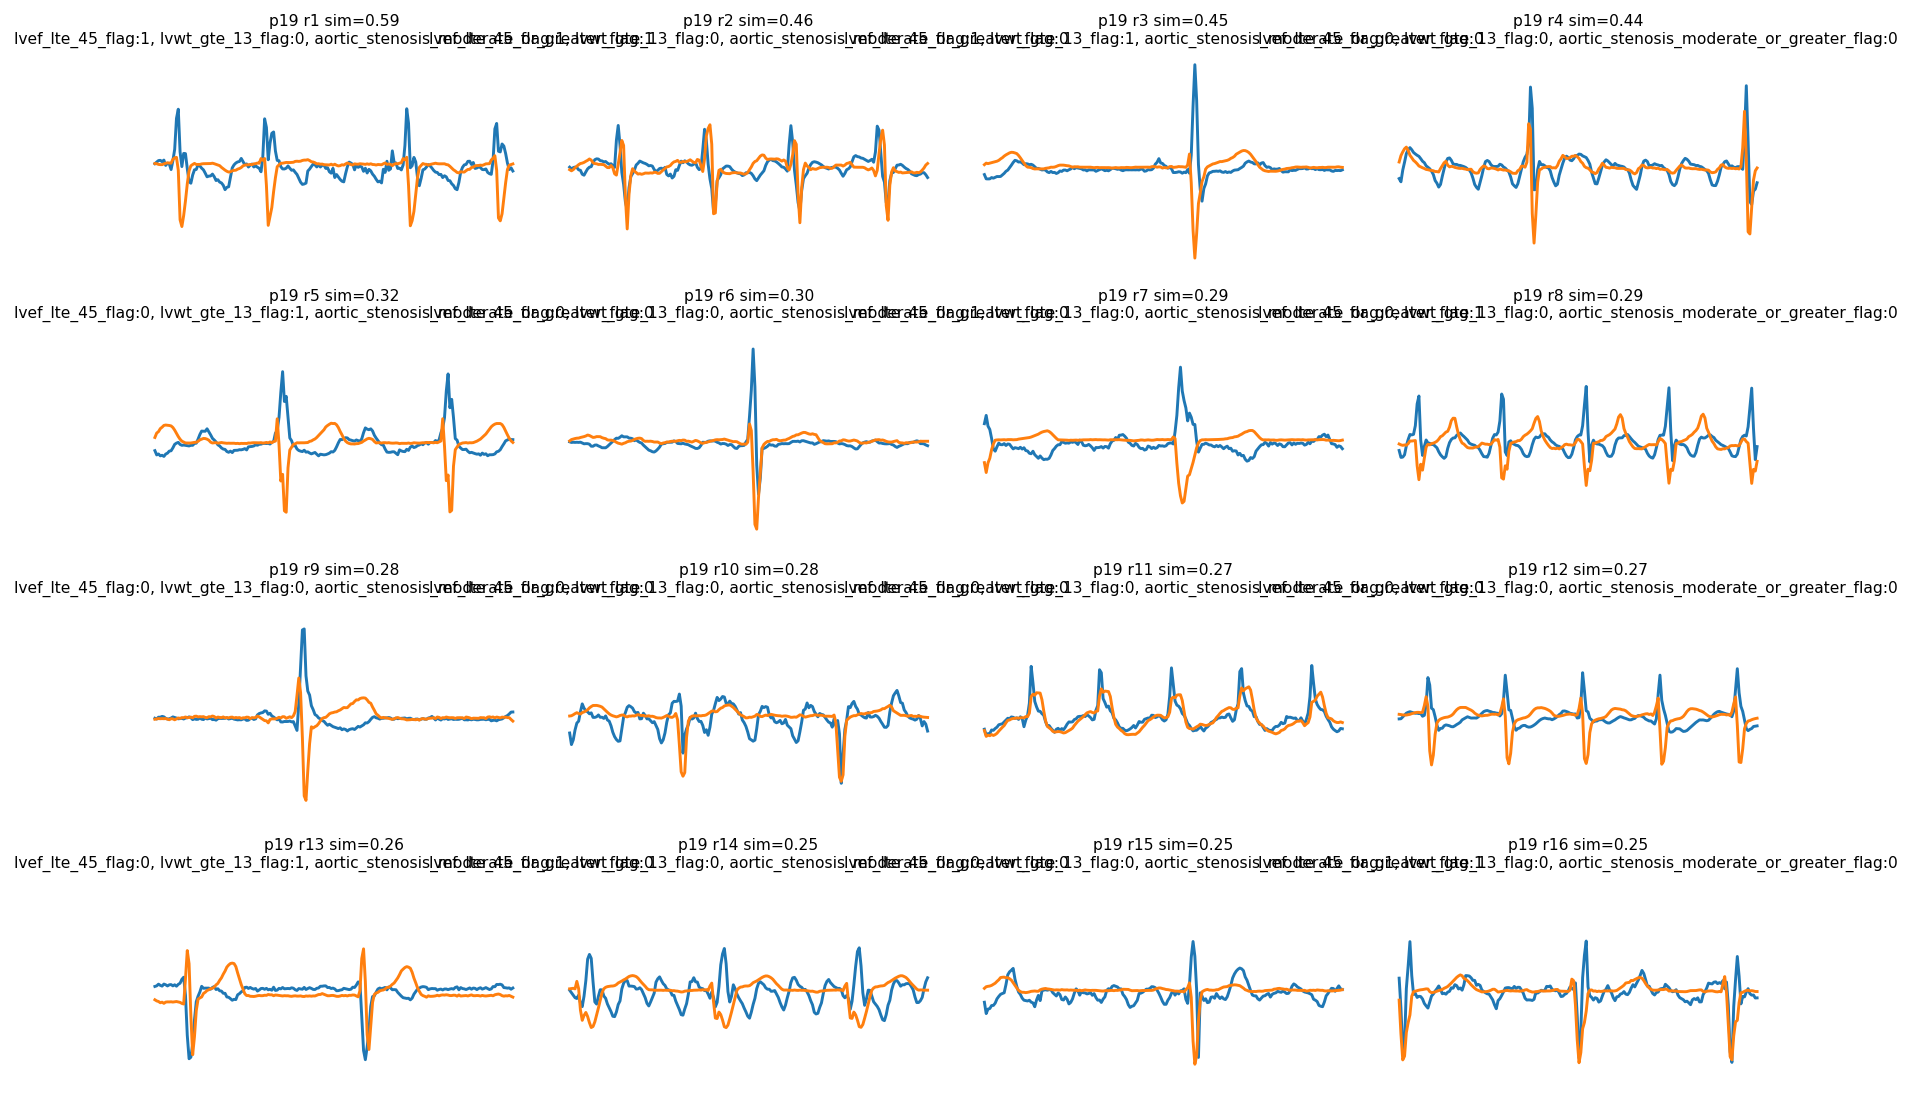

Saved results/echonext_E0_zeroshot/gallery_proto55.png


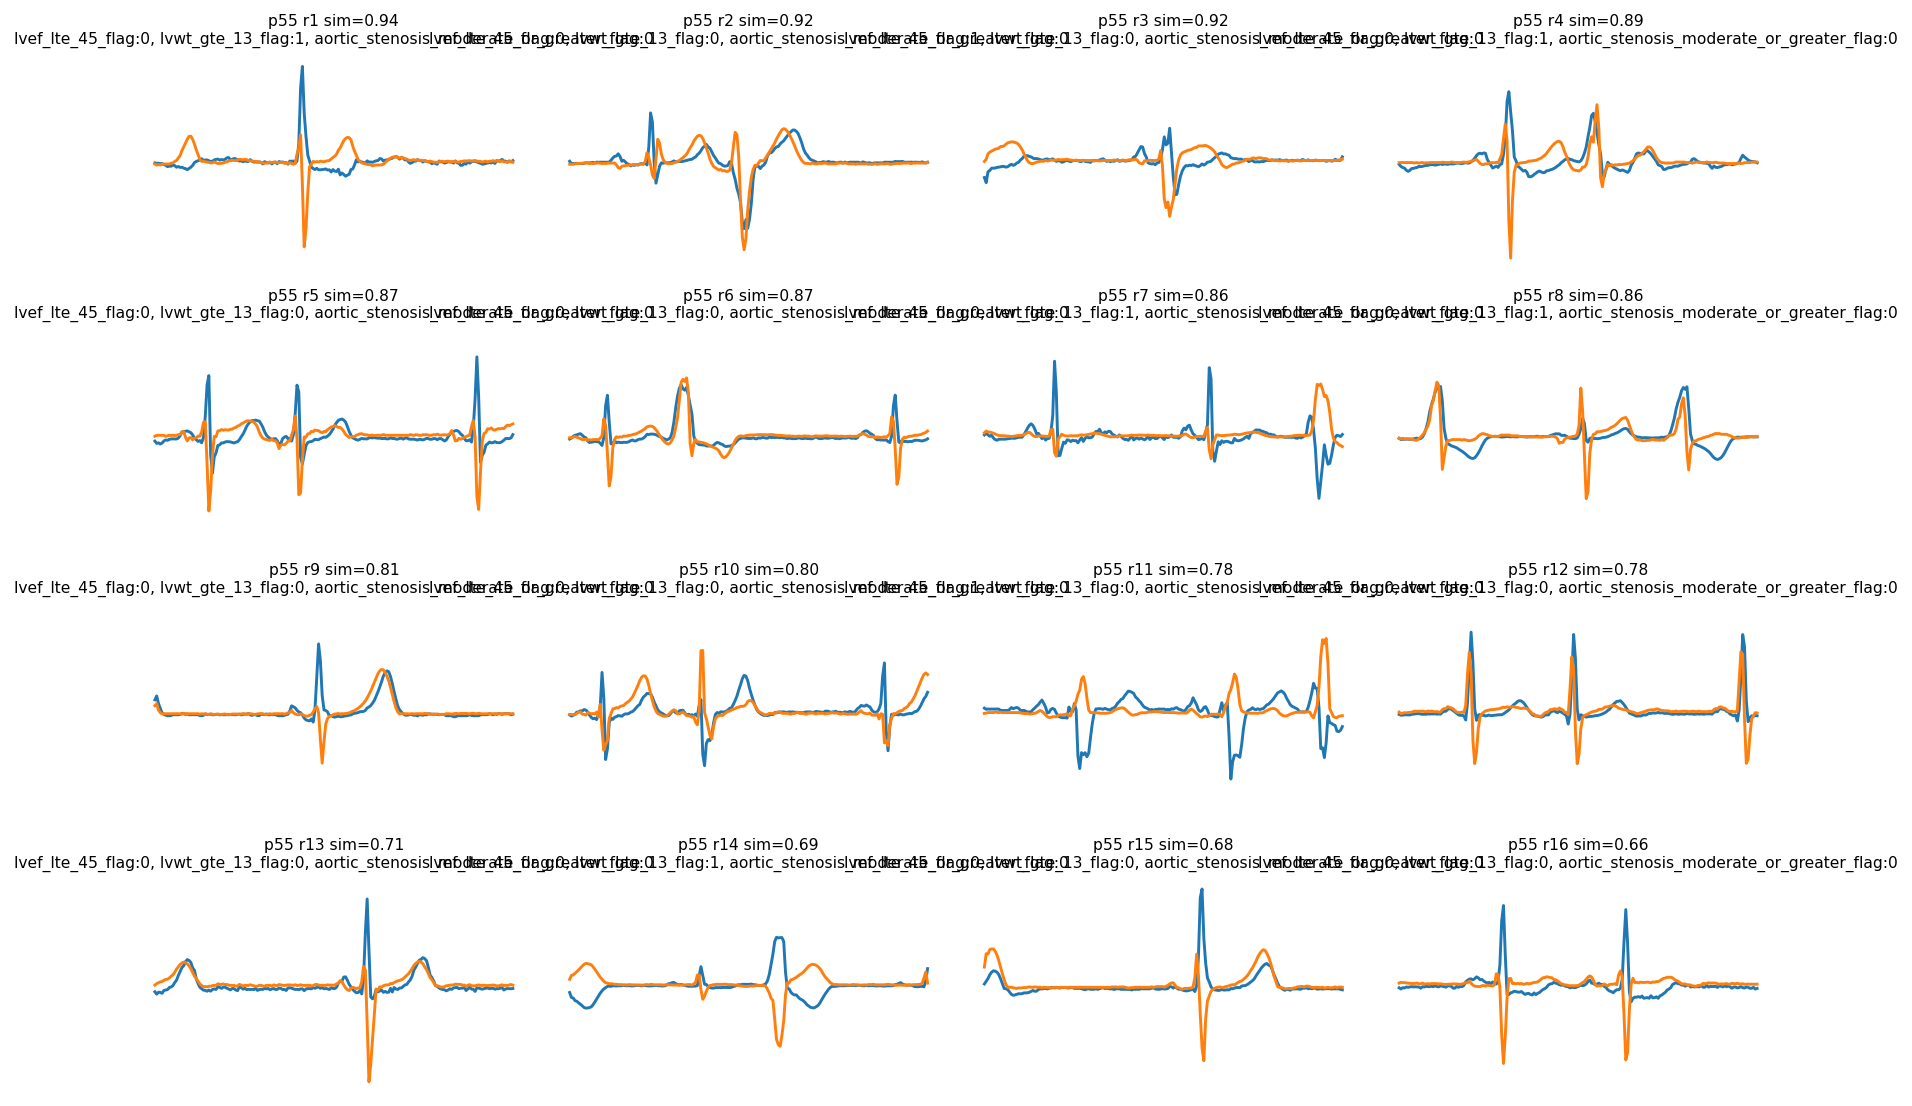

Saved results/echonext_E0_zeroshot/gallery_proto56.png


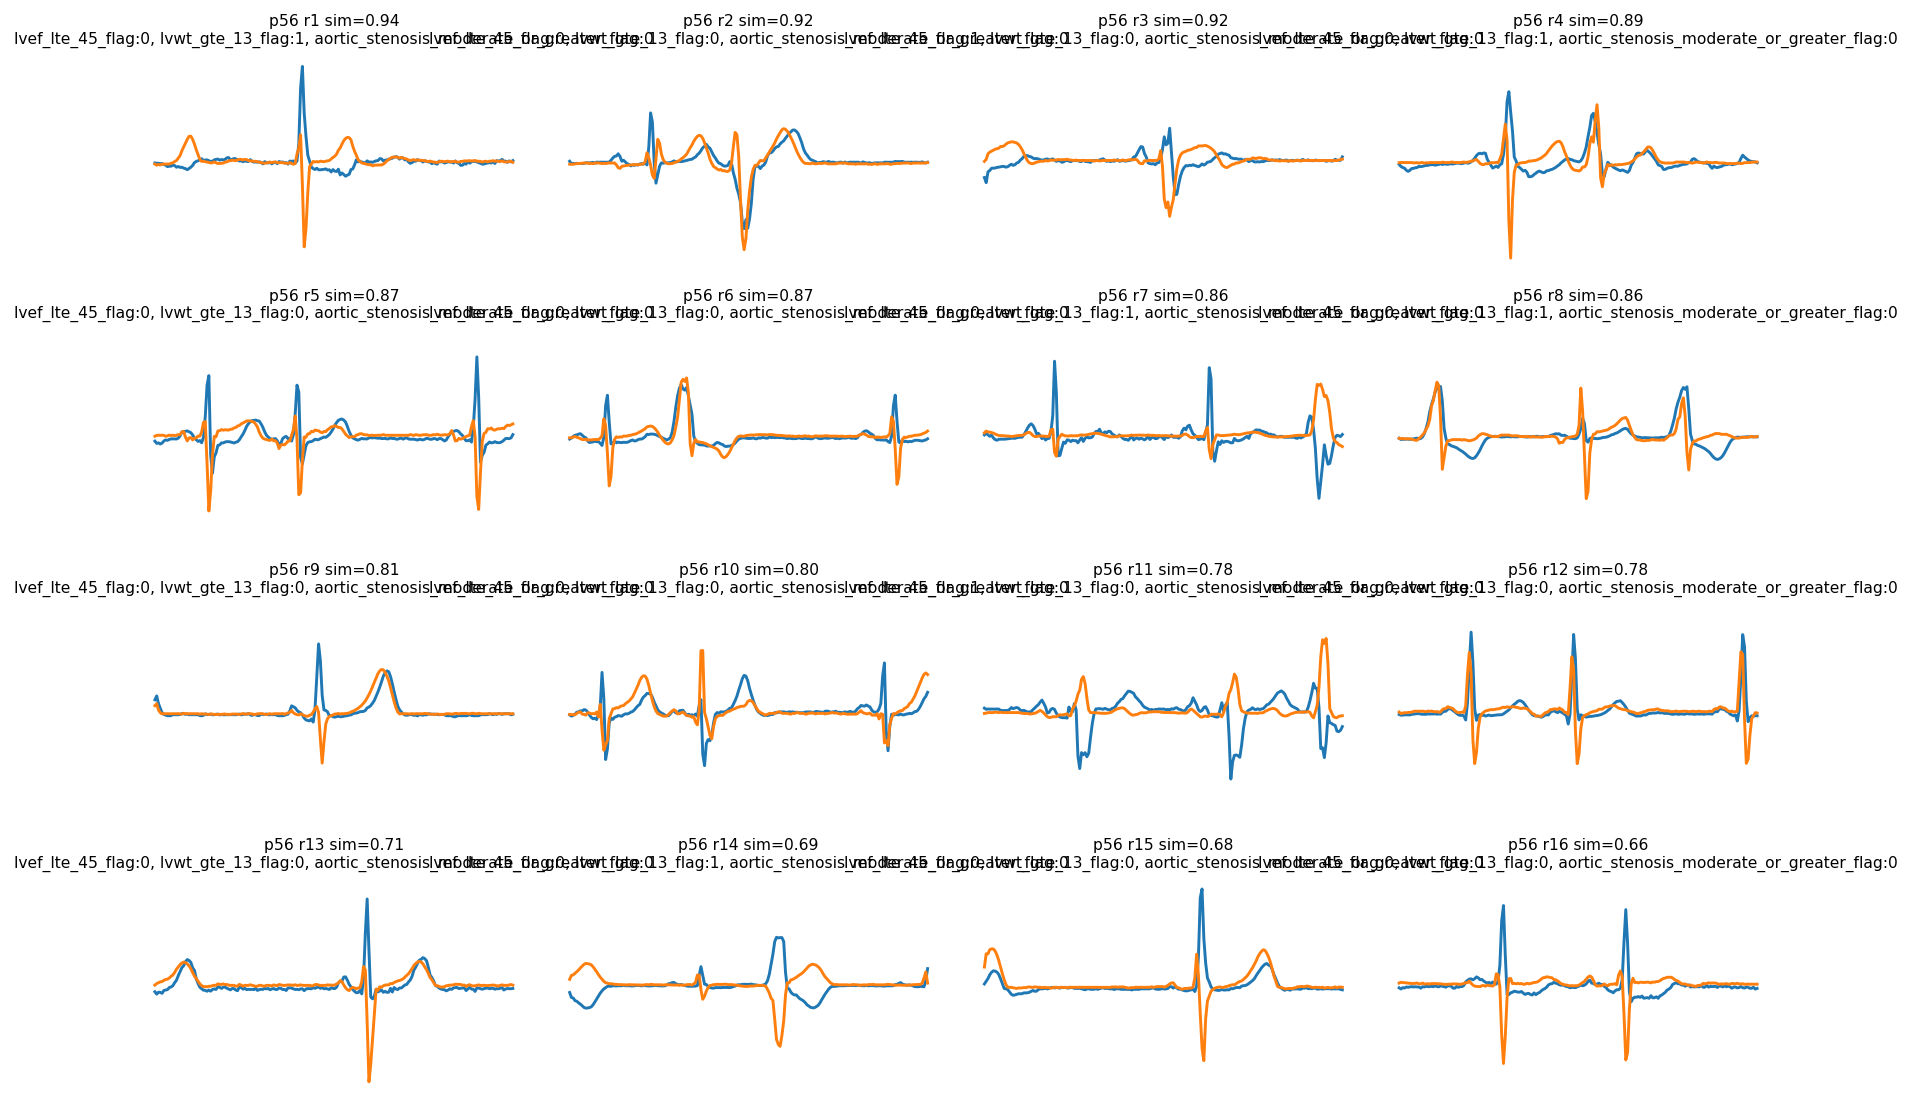

Saved results/echonext_E0_zeroshot/gallery_proto57.png


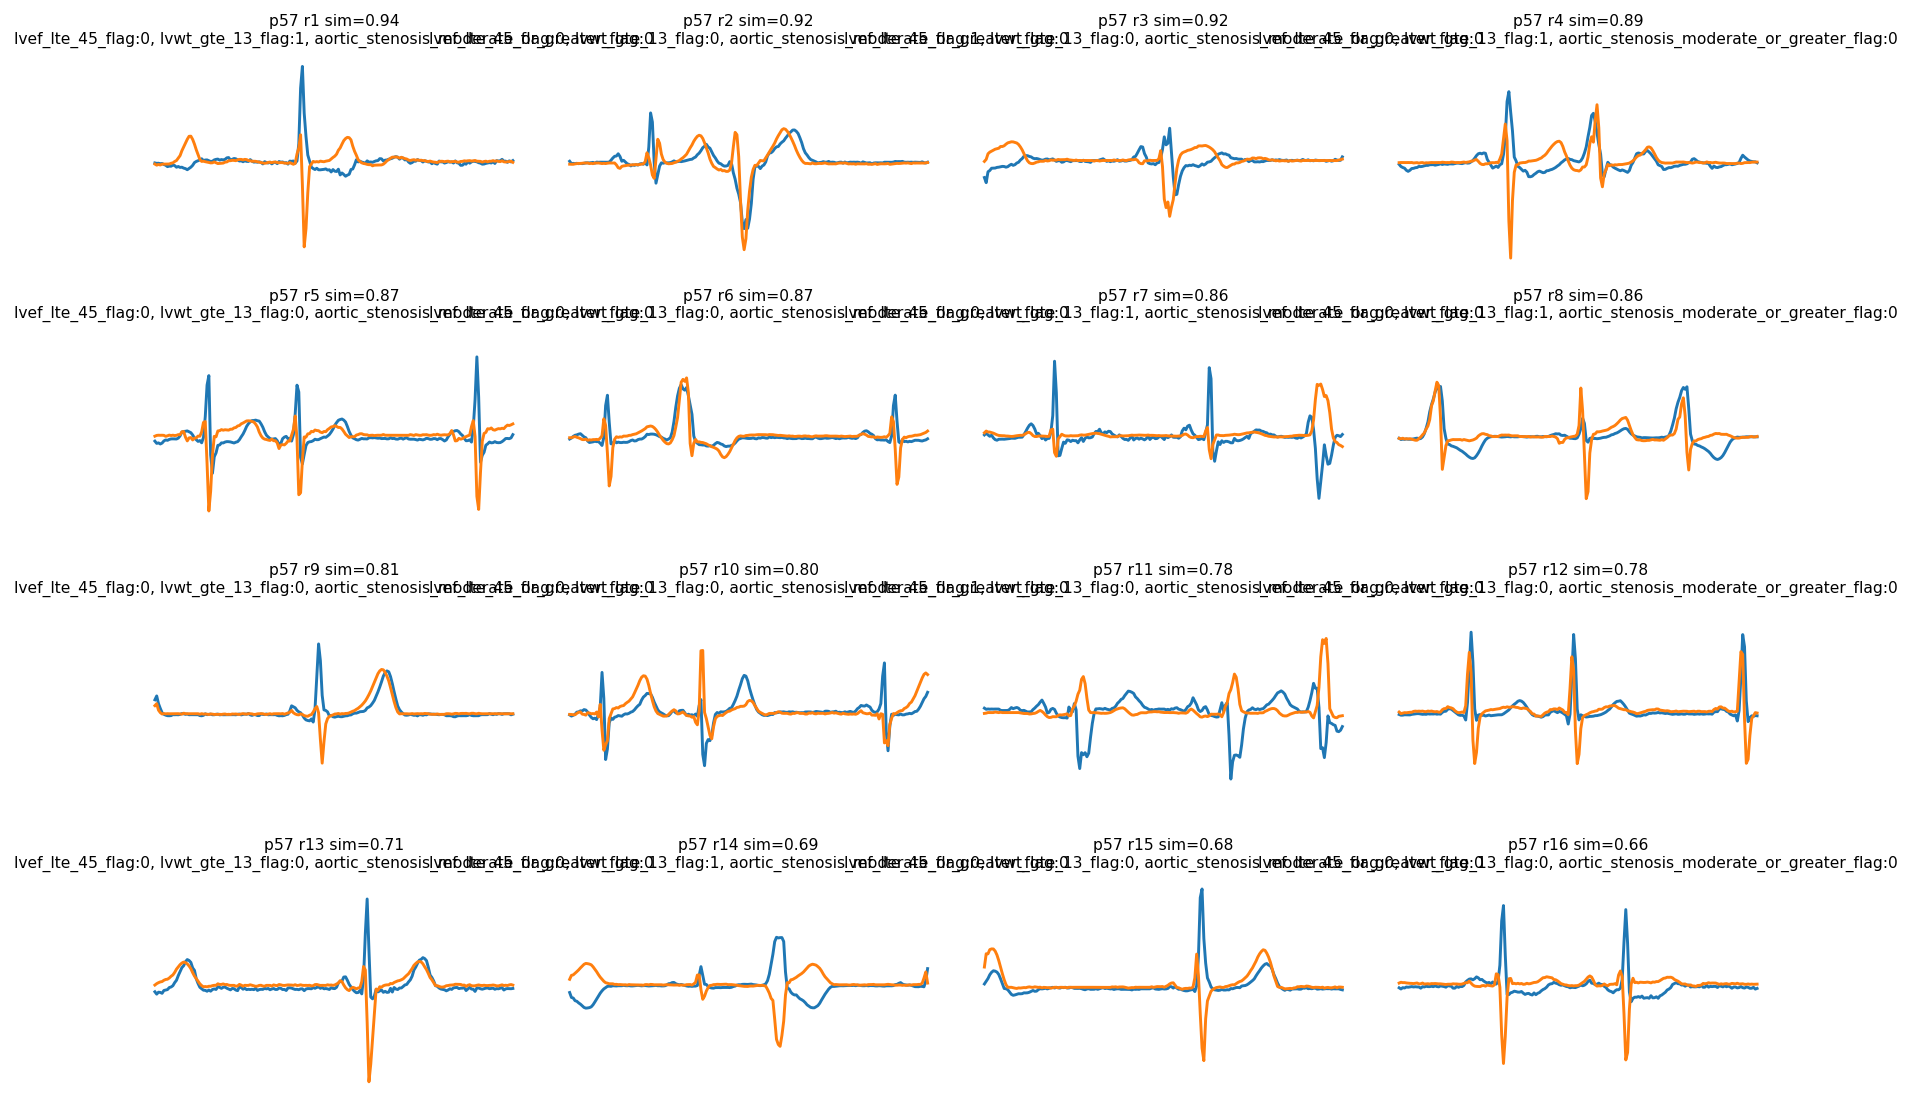

Saved results/echonext_E0_zeroshot/gallery_proto58.png


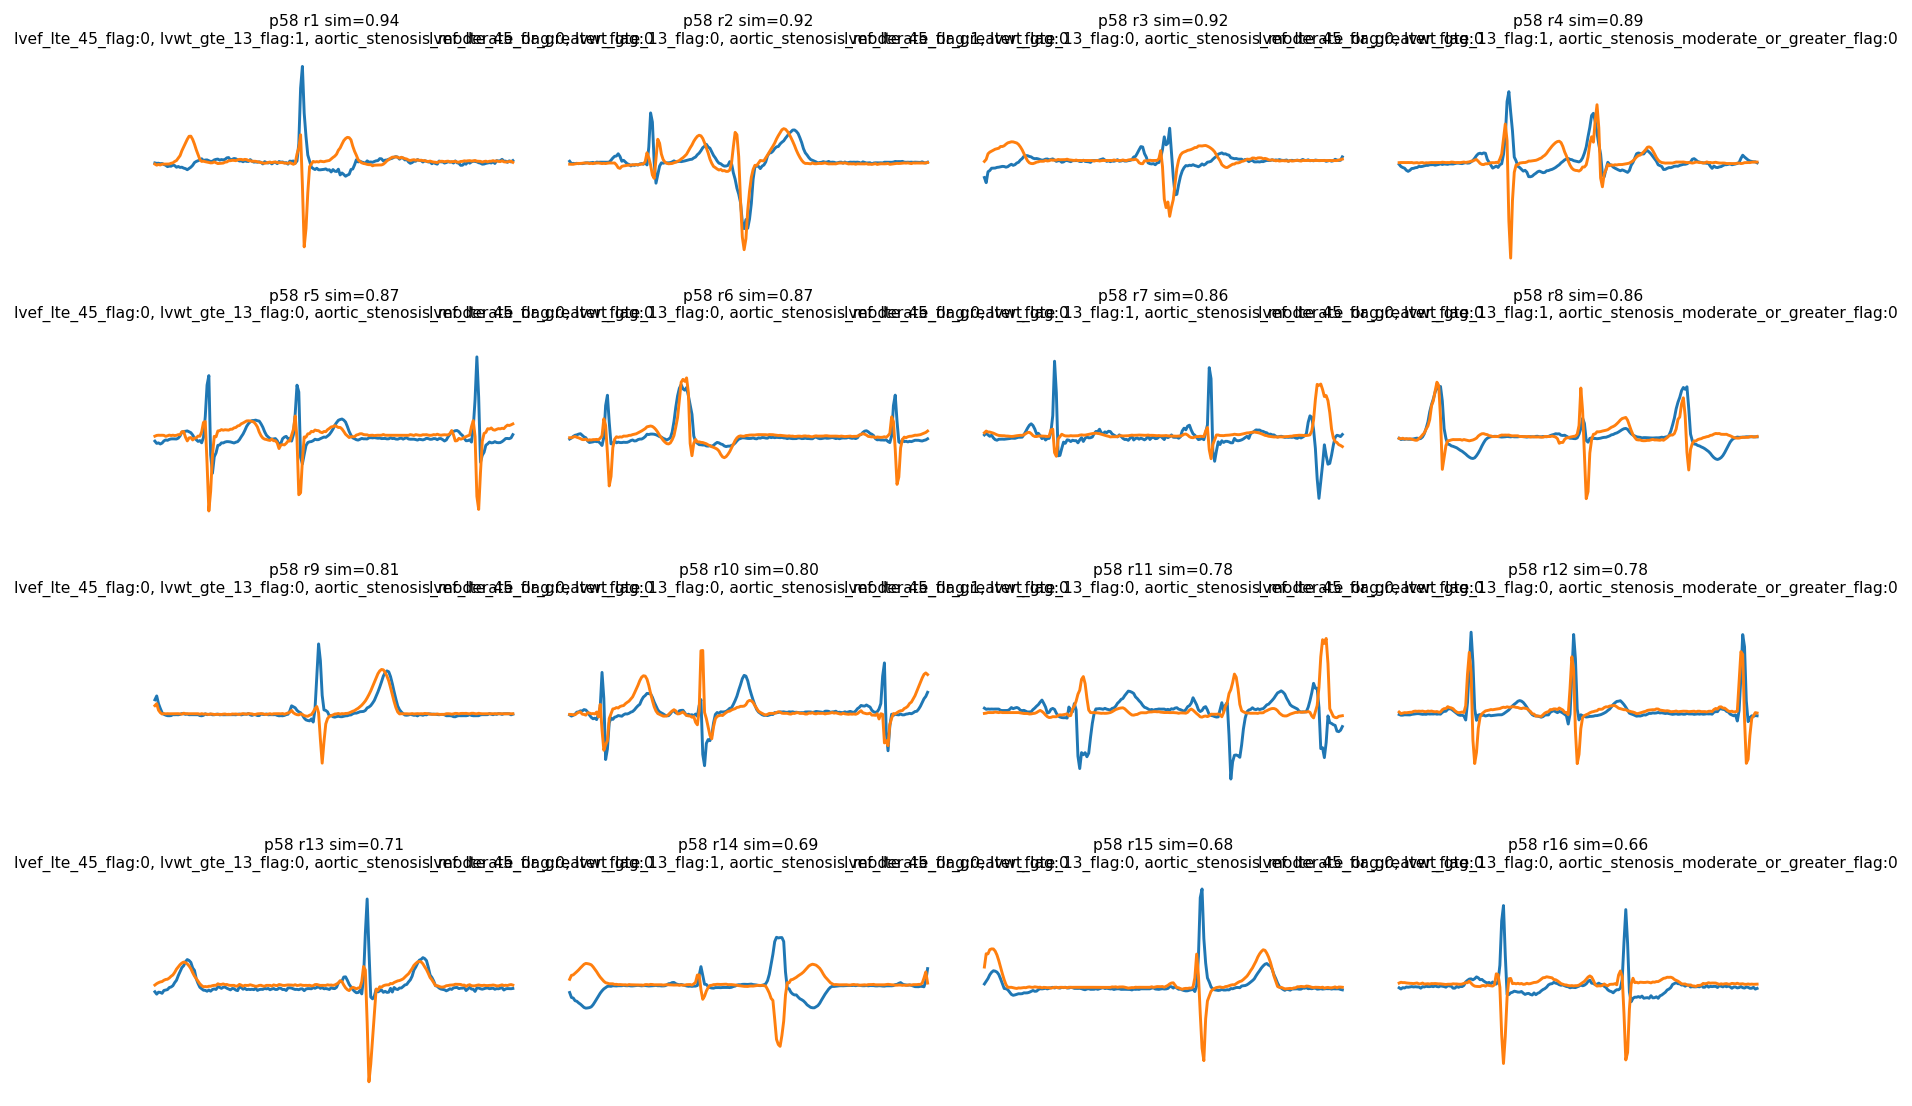

Saved results/echonext_E0_zeroshot/gallery_proto59.png


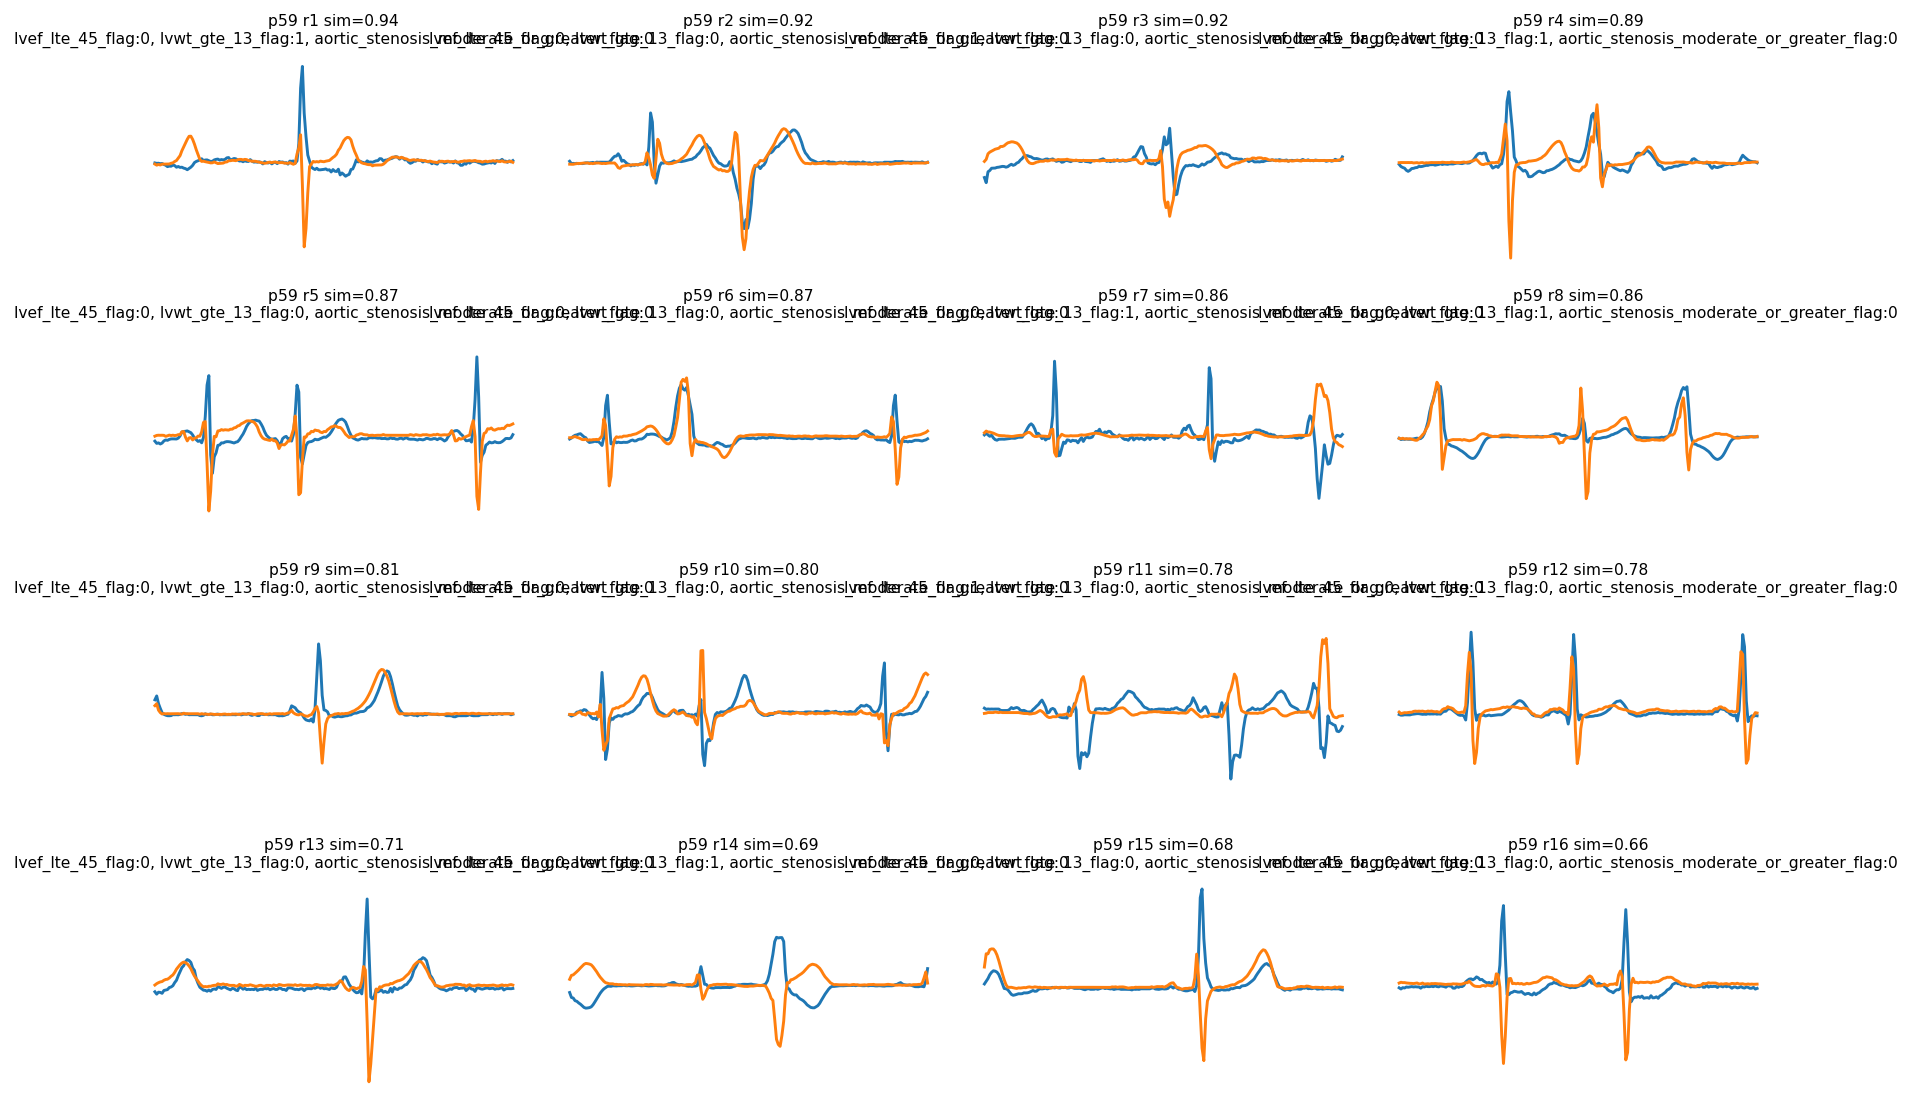

In [83]:
import matplotlib.pyplot as plt

SAVE_PNGS = True
ROWS, COLS = 4, 4     # 16 examples per gallery

def plot_proto_gallery(proto_id, rows=ROWS, cols=COLS):
    sub = hits_df[hits_df["prototype"] == proto_id].sort_values("rank").head(rows*cols)
    if sub.empty:
        print(f"No hits for prototype {proto_id}.")
        return
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.0, rows*2.0), sharex=True, sharey=True)
    axes = axes.ravel()
    for ax, (_, r) in zip(axes, sub.iterrows()):
        i = int(r["sample_index"])
        # Use the argmax time index for this proto to center a window
        tidx = Tidx_test[i, proto_id]  # from earlier npz
        win_size = 200  # samples around max (~2s at 100Hz; adjust as needed)
        s = max(0, tidx - win_size // 2)
        e = min(WAV_test.shape[-1], s + win_size)
        # plot 1–2 representative leads (II + V2)
        lead_names = [1, 7]  # 0-based indices (lead II ~ 1, V2 ~ 7 if standard order)
        for ld in lead_names:
            ax.plot(WAV_test[i, ld, s:e])
        ybits = [f"{nm}:{int(Y_test_full[i, j])}" for j, nm in enumerate(label_names)]
        ax.set_title(f"p{proto_id} r{int(r['rank'])} sim={r['sim']:.2f}\n" + ", ".join(ybits[:3]), fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    if SAVE_PNGS:
        outp = OUTDIR_E0 / f"gallery_proto{proto_id}.png"
        plt.savefig(outp, dpi=180)
        print("Saved", outp)
    plt.show()

# Example: Generate for top prototypes (customize list based on your AUC table)
key_protos = [0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 55, 56, 57, 58, 59]  # from earlier topk
for p in key_protos:
    plot_proto_gallery(p)

# V0

In [86]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
from src.proto_models1D import ProtoECGNet1D  # your repo

# Updated make_loader to support shuffle
def make_loader(split, batch_size=BATCH_SIZE, shuffle=False):
    meta_split = meta[meta["split"] == split]
    waveforms_path = WAVEFORMS_NPY_PATHS[split]
    ds = EchoNextSplitDataset(meta_split, waveforms_path)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

# Reuse E0 model (unfreeze for finetune)
model.train()  # switch to train mode
for p in model.parameters():
    p.requires_grad_(True)  # unfreeze all

# New linear head on prototype activations (80 -> 12)
head = nn.Linear(80, 12).to(DEVICE)

# Loss: BCE for multi-label
criterion = nn.BCEWithLogitsLoss()

# Optimizer/scheduler (optimize model + head)
optimizer = optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# Loaders
train_loader = make_loader("train", batch_size=64, shuffle=True)
val_loader = make_loader("val", batch_size=128, shuffle=False)
test_loader = make_loader("test", batch_size=128, shuffle=False)

# Training loop
epochs = 20
best_val_auc = 0
for epoch in range(epochs):
    model.train()
    head.train()
    train_loss = 0
    for xb, yb in train_loader:
        x = xb.squeeze(1).to(DEVICE)
        y = yb.to(DEVICE)
        sims = model(x)[2]  # prototype activations (B, 80) from forward tuple
        logits = head(sims)  # (B, 12)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Val eval
    model.eval()
    head.eval()
    with torch.no_grad():
        y_true, y_pred = [], []
        for xb, yb in val_loader:
            x = xb.squeeze(1).to(DEVICE)
            sims = model(x)[2]
            out = head(sims).sigmoid().cpu().numpy()  # probs (B, 12)
            y_pred.append(out)
            y_true.append(yb.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        val_auc = np.nanmean([roc_auc_score(y_true[:,j], y_pred[:,j]) for j in range(12) if y_true[:,j].var() > 0])
        val_prc = np.nanmean([average_precision_score(y_true[:,j], y_pred[:,j]) for j in range(12) if y_true[:,j].var() > 0])

    scheduler.step(-val_auc)  # minimize negative AUC
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_macro_auc={val_auc:.4f}, val_macro_prc={val_prc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
        }, OUTDIR_E0.parent / "v0_finetuned.pth")  # save best

# After training: Test eval
model.eval()
head.eval()
with torch.no_grad():
    y_true_te, y_pred_te = [], []
    for xb, yb in test_loader:
        x = xb.squeeze(1).to(DEVICE)
        sims = model(x)[2]
        out = head(sims).sigmoid().cpu().numpy()
        y_pred_te.append(out)
        y_true_te.append(yb.numpy())
    y_true_te = np.concatenate(y_true_te)
    y_pred_te = np.concatenate(y_pred_te)
    test_auc = np.nanmean([roc_auc_score(y_true_te[:,j], y_pred_te[:,j]) for j in range(12) if y_true_te[:,j].var() > 0])
    test_prc = np.nanmean([average_precision_score(y_true_te[:,j], y_pred_te[:,j]) for j in range(12) if y_true_te[:,j].var() > 0])
print(f"Test macro_auc={test_auc:.4f}, macro_prc={test_prc:.4f}")

[EchoNextSplitDataset] EchoNext_train_waveforms.npy shape=(72475, 1, 2500, 12) format=N1T12 | rows=72475
[EchoNextSplitDataset] EchoNext_val_waveforms.npy shape=(4626, 1, 2500, 12) format=N1T12 | rows=4626
[EchoNextSplitDataset] EchoNext_test_waveforms.npy shape=(5442, 1, 2500, 12) format=N1T12 | rows=5442
Epoch 0: train_loss=0.3833, val_macro_auc=0.7173, val_macro_prc=0.2550
Epoch 1: train_loss=0.2970, val_macro_auc=0.7361, val_macro_prc=0.2629
Epoch 2: train_loss=0.2864, val_macro_auc=0.7504, val_macro_prc=0.2710
Epoch 3: train_loss=0.2809, val_macro_auc=0.7517, val_macro_prc=0.2751
Epoch 4: train_loss=0.2765, val_macro_auc=0.7600, val_macro_prc=0.2760
Epoch 5: train_loss=0.2720, val_macro_auc=0.7644, val_macro_prc=0.2806
Epoch 6: train_loss=0.2671, val_macro_auc=0.7657, val_macro_prc=0.2837
Epoch 7: train_loss=0.2628, val_macro_auc=0.7675, val_macro_prc=0.2786
Epoch 8: train_loss=0.2581, val_macro_auc=0.7727, val_macro_prc=0.2842
Epoch 9: train_loss=0.2533, val_macro_auc=0.7702, val